# Where we are at
- So far, we used NSGA2 to determine the top features in the Kimianet Dataset
    - We re-ran the algorithm 10 times after making slight changes: (1) instead of splitting the Kimianet validation data into training/test sets, we made the training set equal to the entire Kimianet validation data, and the test set equal to the entire Kimianet test data (2) when calcuating the test error of the solutions in the final pareto front of each run, we iterated through each test set sample and found the 5 nearest test set neighbours instead of the 5 nearest training set neighbours
- We also stored the number of times each feature showed up in a solution at the final pareto front of each of the NSGA2 runs 
- Next, we analyzed the results of each run's final pareto front even further:
    - Across all 10 runs, we found the solution with the lowest training error as well as the solution with the lowest test error
    - Across all 10 runs, we found the average number of features used in the solutions with the lowest training error and the solutions with the lowest test error
    - Across all 10 runs, we found the average training error from the 10 solutions with the lowest training error, as well as the average test error from the 10 solutions with the lowest test error

# Next Steps
- Take the top 100 features (based on the number of times each feature was selected in a final pareto front solution from the 10 runs)
- Using the features selected from above, implement and run the GDE3 algorithm using pymoo to determine optimal weighting for each feature.
    - Objectives: 
        1. KNN error (f1 score)
        2. number of features used (i.e., number of features with a weight > epsilon, where epslion may be 0.001)
    - Initialization (similar to NSGA2):
        1. randomly generate 100 integers between 0 and n (where n=number of features)
        2. Assign each integer (i) to a solution (s) in the initial population, and randomly generate a weight between 0-1 for i randomly chosen features in solution s. For the remaining unchosen features, assign a weight of 0. The sum of the feature weights should equal 1.
# How is weighting determined using GDE3?
- Feature weighting is another multi-objective optimization problem
    - Objective 1: KNN error
    - Objective 2: number of features used (an unused feature is detected as having a weight less than Epsilon (e.g., Epsilon = 0.001))
- However, the difference here is that the space of potential solutions is continuous, not binary
    - Feature selection is binary: each solution selects some features (1) and ignores the other features (0)
    - Feature weighting is continuous: each solution assigns every feature a weight between 0 and 1, and the sum of the feature weights must equal to 1
- In order to determine optimal weights, the following steps are done:
    1. 


# NEXT STEPS:
- make the algorithm so that, whenever a feature has a weight less than epsilon, before running KNN, change that feature's weight to 0
- make the algorithm so that, whenever a new solution gets generated, we change each features weight less than epsilon to be exactly 0. This helps with future mutations if that solution is chosen
- Params for GDE3 are good, no need to change that. 

In [1]:
from random import randint
import numpy as np
import os
from sklearn.metrics import f1_score
from scipy.spatial import distance_matrix
from collections import Counter
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoode.algorithms import GDE3 # new addition
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.core.population import Population
from pymoo.core.evaluator import Evaluator
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import accuracy_score # for calculating accuracy of model
import math
import matplotlib.pyplot as plt
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.indicators.hv import HV
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Flatten

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [11]:
# Fetch top 100 features, run KNN on it using validation/testing data to get baseline results
# NOTE: csv contains feature names from 1-1024, NOT feature indices from 0-1023
def top_features_accuracy(num_features):
    print("*"*25, f"Top {num_features} Features", "*"*25)
    top_features = pd.read_csv("Top_NSGA2_Features.csv").head(num_features)
    print(top_features)
    print("*"*25, f"Error Using Top {num_features} Features", "*"*25)
    validation_path = "KimiaNet_Data/kimianet_validation_data_averaged_feature_vectors.csv"
    validation = pd.read_csv(validation_path)
    dclass = validation.columns[0]
    xval = validation.drop(columns=[dclass])
    yval = validation[dclass]
    test_path = "KimiaNet_Data/kimianet_test_data_averaged_feature_vectors.csv"
    test = pd.read_csv(test_path)
    dclass = test.columns[0]
    xtest = test.drop(columns=[dclass])
    ytest = test[dclass]
    def knn(x, y, top_features):
        featureNames = []
        for i in top_features['Feature'].tolist():
            featureNames.append(x.columns[i-1]) # e.g., if csv says feature 12, it's located at index 11 in x
        x = x[featureNames]
        dist_matrix = distance_matrix(x, x) 
        predy = [] 
        for i in range(len(x)):
            distances = dist_matrix[i]
            distances[i] = np.inf
            nearest_neighbors = np.argsort(distances)[:5]
            neighbor_labels = y[nearest_neighbors]
            most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
            predy.append(most_common_label)
        f1 = f1_score(y, predy, average='weighted')
        return 1 - f1
    val_error = knn(xval, yval, top_features)
    test_error = knn(xtest, ytest, top_features)
    print(f"F1 Score Error using only validation data: {round(val_error, 4)}")
    print(f"F1 Score Error using only test data: {round(test_error, 4)}")
    return val_error, test_error

feature_counts = [10, 20, 30, 40, 50, 75, 100, 200, 400, 600, 800, 1024]
val_errors = []
test_errors = []
for count in feature_counts:
    val_error, test_error = top_features_accuracy(count)
    val_errors.append(val_error)
    test_errors.append(test_error)
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, val_errors, marker='o', label='Validation Error', color='powderblue')
plt.plot(feature_counts, test_errors, marker='o', label='Test Error', color='orange')
plt.xlabel('Number of Features')
plt.ylabel('Error (1 - F1 Score)')
plt.title('Validation and Test Error with Top Features')
plt.legend()
plt.grid(True)
plt.show()

************************* Top 10 Features *************************
   Feature  Occurrences
0     1022          114
1      996           99
2      976           99
3      708           89
4      766           86
5      955           85
6      630           82
7      881           79
8      793           78
9      545           77
************************* Error Using Top 10 Features *************************
F1 Score Error using only validation data: 0.2217
F1 Score Error using only test data: 0.2576
************************* Top 20 Features *************************
    Feature  Occurrences
0      1022          114
1       996           99
2       976           99
3       708           89
4       766           86
5       955           85
6       630           82
7       881           79
8       793           78
9       545           77
10      769           75
11      781           74
12      855           73
13      767           72
14      819           69
15      841           65
1

In [62]:
'''
we need to define objectives with f1 and f2
what are constraints? we have an inequality constraint here?
Constraints are used to filter out invalid solutions. Solutions violating the constraint (where the constraint value is positive) will be penalized, and thus, the optimizer will avoid selecting such solutions
In the case of NSGA2, we used a constraint of 1-sum(bitstring) to penalize solutions that selected no features (since sum(bitstring) would be 0 in that case, resulting in the constraint being violated since we end up with a positive value (1-0=1))

For GDE3, we still want to keep this constraint to avoid solutions that don't select any features. 
However, our solutions are no longer binary with 0s and 1s. So, if a solution assigns a weight >0 to any feature,
we know that solution considers at least one feature. Therefore, if sum(solution)>0, the constraint is not violated.
We can translate that to a constraint as epsilon-sum(solution), where epsilon is an extremely small positive number.
If we replace epsilon with 0, that's incorrect since 0-sum(solution) for a solution with no weights for any feature is 0, which Pymoo doesn't recognize as a violated constraint since it isn't positive.

We do not need a constraint to ensure sum(weights)=1. Rather, we normalize all weights within classification_error before calculating the KNN error
However maybe its a good idea to apply this constraint to limit the search space?
No, it makes the process inflexible
'''


class MyProblem(Problem):

    def __init__(self, xtrain, ytrain, epsilon = 0.01):
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.epsilon = epsilon
        n_features = xtrain.shape[1]  # Number of features (columns in xtrain)
        xl = np.full(n_features, 0)  # lower bound 0 for all feature weights
        xu = np.full(n_features, 1)  # upper bound 1 for all feature weights
        super().__init__(n_var=n_features, # decision variables
                         n_obj=2, # two objective functions
                         n_ieq_constr=1, # one inequality constraint
                         xl=xl, # lower bound on all decision variables (feature weights)
                         xu=xu) # upper bound on all decision variables (feature weights)

    def __classification_error__(self,weights): # objective 1: minimize classification error
        # instead of a bitstring, we use an array/vector consisting of a weight for each feature
        weights = np.where(weights < self.epsilon, 0, weights) # replace all weights < epsilon with 0
        if np.sum(weights) > 0:
            weights_normalized = weights / np.sum(weights) # normalize weights so that the sum of weights is 1
        else:
            weights_normalized = weights
        # weights_normalized = [x / sum(weights) for x in weights] 
        trainx = self.xtrain * weights_normalized # multiply each column by its respective weights
        trainy = self.ytrain
        # Implement leave-one-out KNN and return error using f1 score
        trainxknn = trainx.reset_index(drop=True)
        trainyknn = trainy.reset_index(drop=True)
        dist_matrix = distance_matrix(trainxknn, trainxknn) 
        predy = [] 
        for i in range(len(trainxknn)):
            distances = dist_matrix[i]
            distances[i] = np.inf
            nearest_neighbors = np.argsort(distances)[:5]
            neighbor_labels = trainyknn[nearest_neighbors]
            most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
            predy.append(most_common_label)
        f1 = f1_score(trainyknn, predy, average='weighted')
        return 1 - f1

    def __features_number__(self,weights): # objective 2: minimize the number of features used; a used feature is identified by having a weight greater than epsilon
        return np.sum(weights > self.epsilon)

    def __constrain__(self,weights): # constraint 1: sum of weights must be >= epsilon to penalize solutions that don't assign weights to any features (i.e., solutions that don't use any features)
        return self.epsilon - np.sum(weights)

    def _evaluate(self, x, out, *args, **kwargs):
        x = np.where(x < self.epsilon, 0, x) # for the current generation x, replace all weights < epsilon with 0 for ALL solutions in the generation
        f1 = [self.__features_number__(x[i]) for i in range(0, len(x))]
        f2 = [self.__classification_error__(x[i]) for i in range(0, len(x))]
        g1 = [self.__constrain__(x[i]) for i in range(0, len(x))]
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1])


def generate_individuals(total_features, epsilon, popsize):
    num_features_selected = np.random.randint(0, total_features, size=popsize)
    population = []
    i=1
    for num_selected in num_features_selected:
        individual = np.zeros(total_features)
        if num_selected > 0:
            selected_indices = np.random.choice(range(total_features), size=num_selected, replace=False)
            individual[selected_indices] = np.random.uniform(epsilon, 1, size=num_selected)  # Set selected features to have a random weight between epsilon-1
            print(f"INDIVIDUAL {i}, {num_selected} features: {individual[:10]}...")
        population.append(individual)
        i+=1
    return np.array(population)


def visualize(res, xtrain, ytrain, xtest, ytest, epsilon):

    hv_values = []
    num_unique_features = []
    feature_weights_sum = np.zeros(len(res.history[0].opt.get("X")[0]))
    total_solutions = 0

    # Loop through each iteration in the NSGA2 history
    for i in range(len(res.history)):
        # Get the Pareto front at iteration i
        pareto_front_F = res.history[i].opt.get("F")
        pareto_front_X = res.history[i].opt.get("X")
        # Calculate HV
        '''
        ref_point = np.array([1, 1])
        ind = HV(ref_point=ref_point)
        scaler = MinMaxScaler()
        hv = ind(scaler.fit_transform(pareto_front_F))
        '''
        pareto_front_F_scaled = pareto_front_F.copy()
        pareto_front_F_scaled[:, 0] = pareto_front_F_scaled[:, 0] / xtrain.shape[1] 
        ref_point = np.array([1, 1])
        ind = HV(ref_point=ref_point)
        hv = ind(pareto_front_F_scaled)
        hv_values.append(hv)
        # Calculate number of features used across all solutions in this iteration
        selected_features = np.array(pareto_front_X) > epsilon
        unique_features = np.sum(np.any(selected_features, axis=0))
        num_unique_features.append(unique_features)
        # Calculate total feature weights across all solutions in this iteration
        feature_weights_sum += np.sum(pareto_front_X, axis=0)
        total_solutions += len(pareto_front_X)

    # Plot HV history
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(hv_values) + 1), hv_values, marker='o', color='powderblue')
    plt.title('HV Value of Pareto Front Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('HV Value')
    plt.show()

    # Plot feature usage history
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(num_unique_features) + 1), num_unique_features, marker='o', color='orange')
    plt.title('Number of Features Used Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Number of Features')
    plt.show()

    # Plot average feature weights
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(res.history[0].opt.get("X")[0])), feature_weights_sum / total_solutions, color='palegreen')
    plt.title('Average Feature Weights')
    plt.xlabel('Feature Index')
    plt.ylabel('Average Weight')
    plt.show()

    # Plot initial pareto front
    i_f = res.history[0].opt.get("F")
    i_pop = res.history[0].pop
    print(f"Total population members: {len(i_pop)}")
    print(f"Pareto front members: {len(i_f)}")
    plt.scatter(i_pop.get("F")[:,0], i_pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
    plt.scatter(i_f[:,0], i_f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
    plt.xlabel('number of features')
    plt.ylabel('training error')
    plt.legend()
    plt.title("Initial Pareto Front")
    plt.show()

    # Plot final pareto front
    f = res.F
    pop = res.pop
    solutions = res.X
    print(f"Total population members: {len(pop)}")
    print(f"Pareto front members: {len(f)}")
    plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
    plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
    plt.xlabel('number of features')
    plt.ylabel('training error')
    plt.legend()
    plt.title("Final Pareto Front")
    plt.show()

    # Plot final pareto front using test accuracy
    final_pf_results = {}
    # Store information on pareto front results
    print("#"*50)
    print("Pareto Front Solution Details")
    for s in range(len(solutions)):
        solution = solutions[s] # solution represents a vector of feature weights
        solution = np.where(solution < epsilon, 0, solution) # replace all weights < epsilon with 0
        print("solution " + str(s) + ":")
        print("number of selected features is: " + str(f[:,0][s])) # i.e., number of features with a weight greater than epsilon
        #indices = [i + 1 for i, x in enumerate(np.multiply(solution, 1)) if x == 1]
        #print("corresponding indices: " + str(indices))
        print('corresponding weights: ', solution[:10], '...')
        if np.sum(solution) > 0:
            solution_normalized = solution / np.sum(solution) # normalize weights so that the sum of weights is 1
        else:
            solution_normalized = solution
        print('corresponding normalized weights: ', solution_normalized[:10], '...')
        print("classification error on train sets: " + str(f[:, 1][s]))
        trainx = xtrain * solution_normalized
        testx = xtest * solution_normalized
        trainy = ytrain
        testy = ytest
        '''
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(trainx, trainy.values.ravel())
        predy = knn.predict(testx)
        ac = accuracy_score(testy, predy)
        mce = 1-ac
        '''
        ################################
        '''
        # Here, we use training and test data, since we go through each test element and find the nearest training neighbours. Instead, we want to use test data only, as done below.
        # Implement leave-one-out KNN and return error using f1 score
        trainxknn = trainx.reset_index(drop=True)
        trainyknn = trainy.reset_index(drop=True)
        testxknn = testx.reset_index(drop=True)
        testyknn = testy.reset_index(drop=True)
        dist_matrix = distance_matrix(testxknn, trainxknn) # Calculate distance matrix between all samples using euclidean distance
        predy = [] # arr to store predicted labels
        for i in range(len(testxknn)):
            # Get distances of the current sample to all others
            distances = dist_matrix[i]
            #distances[i] = np.inf # no need to exclude current sample from any its neighbours for test 
            nearest_neighbors = np.argsort(distances)[:5]
            neighbor_labels = trainyknn[nearest_neighbors]
            # Assign most common label among the neighbors to the current sample
            most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
            predy.append(most_common_label)
        # Calculate the F1 score between the predicted and actual labels
        f1 = f1_score(testyknn, predy, average='weighted') # weighted means we calculate f1 score for both labels and take the weighted average between them
        mce = 1 - f1
        '''
        testxknn = testx.reset_index(drop=True)
        testyknn = testy.reset_index(drop=True)
        dist_matrix = distance_matrix(testxknn, testxknn) # Calculate distance matrix between all samples using euclidean distance
        predy = [] # arr to store predicted labels
        for i in range(len(testxknn)):
            # Get distances of the current sample to all others
            distances = dist_matrix[i]
            distances[i] = np.inf # we need to exclude current sample from identifying itself as a neighbour
            nearest_neighbors = np.argsort(distances)[:5]
            neighbor_labels = testyknn[nearest_neighbors]
            # Assign most common label among the neighbors to the current sample
            most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
            predy.append(most_common_label)
        # Calculate the F1 score between the predicted and actual labels
        f1 = f1_score(testyknn, predy, average='weighted') # weighted means we calculate f1 score for both labels and take the weighted average between them
        mce = 1 - f1
        ##################################

        print("classification error on test sets: " + str(mce))
        final_pf_results[s] = {
        'num_selected_features': f[:,0][s],
        'feature_weights': solution.tolist(),
        'train_error': f[:, 1][s],
        'test_error': mce
    }
    print("#"*50)
    # Extract number of features and test error from each pareto front solution
    num_features = [final_pf_results[key]['num_selected_features'] for key in final_pf_results]
    test_errors = [final_pf_results[key]['test_error'] for key in final_pf_results]
    # Find pareto front using test error and create points (num_features, test_error)
    points = list(zip(num_features, test_errors))
    sorted_points = sorted(points, key=lambda x: x[0])  # Sort by number of features
    pareto_front_points = [sorted_points[0]]  # Start with the first point
    for point in sorted_points[1:]:
        if point[1] < pareto_front_points[-1][1]:  # Test error must be lower
            pareto_front_points.append(point)
    # Plot the pareto front
    pareto_features = [p[0] for p in pareto_front_points]
    pareto_errors = [p[1] for p in pareto_front_points]
    print(f"Total population members: {len(num_features)}")
    print(f"Pareto front members: {len(pareto_features)}")
    plt.scatter(num_features, test_errors, edgecolor="blue", facecolor="none", label="solutions")
    plt.scatter(pareto_features, pareto_errors, marker='*', edgecolor="red", facecolor="none", label="optimal pareto front")
    plt.xlabel('Number of Features')
    plt.ylabel('Test Error')
    plt.legend()
    plt.title("Final Pareto Front using Test Error")
    plt.show()

    # Store information on test error pareto front results
    final_test_pf_results = {}
    for idx, (num_feat, test_err) in enumerate(pareto_front_points):
        for key in final_pf_results:
            if (final_pf_results[key]['num_selected_features'] == num_feat) and (final_pf_results[key]['test_error'] == test_err):
                final_test_pf_results[key] = final_pf_results[key]
    print("Final PF Results: ", final_pf_results)
    print("Final Test Error PF Results: ", final_test_pf_results)

    # Get HV results for pareto front using test & training error
    # NOTE: HV will be naturally low since it is very unlikely for weights to be assigned in a way where the number of features selected is close to 0
    # HV using test PF
    pareto_front_array = np.array([[num_feat, test_err] for num_feat, test_err in pareto_front_points])
    '''
    ref_point = np.array([1, 1])
    ind = HV(ref_point=ref_point)
    scaler = MinMaxScaler()
    hv_test = ind(scaler.fit_transform(pareto_front_array))
    '''
    pareto_front_array_scaled = pareto_front_array.copy()
    pareto_front_array_scaled[:, 0] = pareto_front_array_scaled[:, 0] / xtrain.shape[1] 
    ref_point = np.array([1, 1])
    ind = HV(ref_point=ref_point)
    hv_test = ind(pareto_front_array_scaled)
    print("HV of the best pareto front (using test error): " + str(round(hv_test, 5)))
    # HV using training PF
    '''
    ref_point = np.array([1, 1])
    ind = HV(ref_point=ref_point)
    scaler = MinMaxScaler()
    hv_training = ind(scaler.fit_transform(res.F))
    '''
    res_scaled = res.F.copy()
    res_scaled[:, 0] = res_scaled[:, 0] / xtrain.shape[1] 
    ref_point = np.array([1, 1])
    ind = HV(ref_point=ref_point)
    hv_training = ind(res_scaled)
    print("HV of the best pareto front (using training error): " + str(round(hv_training, 5)))

    # Find the solution with the lowest training and testing error
    lowest_train_error_solution = min(final_pf_results.values(), key=lambda x: x['train_error'])
    lowest_test_error_solution = min(final_test_pf_results.values(), key=lambda x: x['test_error'])

    print("Solution with the lowest training error:", lowest_train_error_solution)
    print("Solution with the lowest testing error:", lowest_test_error_solution)

    # Return final results
    return final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training


def store_results(dataset_name, final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training, epsilon, featureNames):
    csv_file_path = "data.csv" # file to store NSGA2 results for different datasets

    # If file doesn't exist, create it
    if not os.path.exists(csv_file_path):
        columns = [
            "Dataset", "Training PF", "Test PF", "HV for training PF", "HV for testing PF",
            "Minimum error on training PF", "Minimum error on testing PF",
            "Number of features for minimum error on training PF",
            "Number of features for minimum error on testing PF",
            "Feature Frequency"
        ]
        df_results = pd.DataFrame(columns=columns)
        df_results.to_csv(csv_file_path, index=False)

    # Otherwise, open the file
    else:
        df_results = pd.read_csv(csv_file_path)

    # Calculate feature frequency (using training PF)
    feature_count = {feature: 0 for feature in featureNames}
    for solution in final_pf_results.values():
        for i, weight in enumerate(solution['feature_weights']):
            if weight > epsilon:
                feature_count[featureNames[i]] += 1
    feature_freq_str = ', '.join([f"{key}: {value}" for key, value in feature_count.items()])

    # Create new row to put in file
    new_row = pd.DataFrame([{
        "Dataset": dataset_name,
        "Training PF": final_pf_results,
        "Test PF": final_test_pf_results,
        "HV for training PF": hv_training,
        "HV for testing PF": hv_test,
        "Minimum error on training PF": lowest_train_error_solution["train_error"],
        "Minimum error on testing PF": lowest_test_error_solution["test_error"],
        "Number of features for minimum error on training PF": lowest_train_error_solution["num_selected_features"],
        "Number of features for minimum error on testing PF": lowest_test_error_solution["num_selected_features"],
        "Feature Frequency": feature_freq_str
    }])

    # Put new row in file
    df_results = pd.concat([df_results, new_row], ignore_index=True)
    df_results.to_csv(csv_file_path, index=False)
    print("Results saved to data.csv")
    return



TOTAL NUMBER OF FEATURES:  100
************************************************** RUN 1 **************************************************
INDIVIDUAL 1, 35 features: [0.         0.         0.         0.         0.72750692 0.
 0.         0.         0.         0.        ]...
INDIVIDUAL 2, 17 features: [0.        0.        0.        0.3087939 0.        0.        0.
 0.        0.        0.       ]...
INDIVIDUAL 3, 41 features: [0.         0.         0.53806622 0.         0.         0.89360892
 0.         0.86903871 0.         0.        ]...
INDIVIDUAL 4, 73 features: [0.98046446 0.45028587 0.49084182 0.93422433 0.918496   0.6406759
 0.29775395 0.         0.         0.82964391]...
INDIVIDUAL 5, 37 features: [0.2839898  0.58360334 0.         0.         0.         0.
 0.71682638 0.         0.88735929 0.        ]...
INDIVIDUAL 6, 4 features: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...
INDIVIDUAL 7, 92 features: [0.         0.08397127 0.82370449 0.93358768 0.41054369 0.81187069
 0.84392744 0.         0.

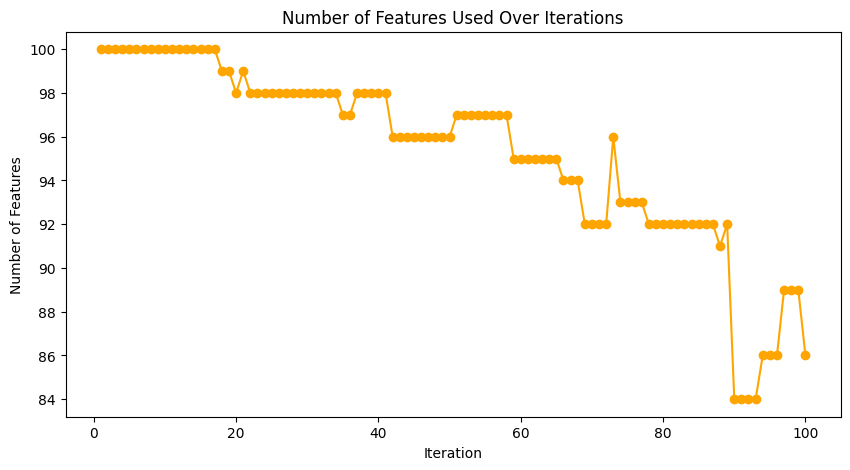

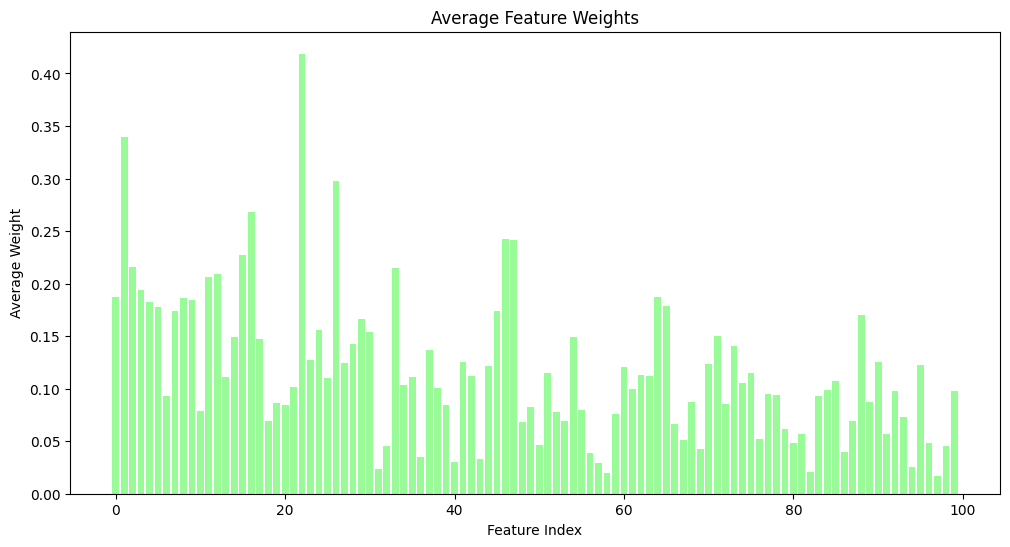

Total population members: 100
Pareto front members: 19


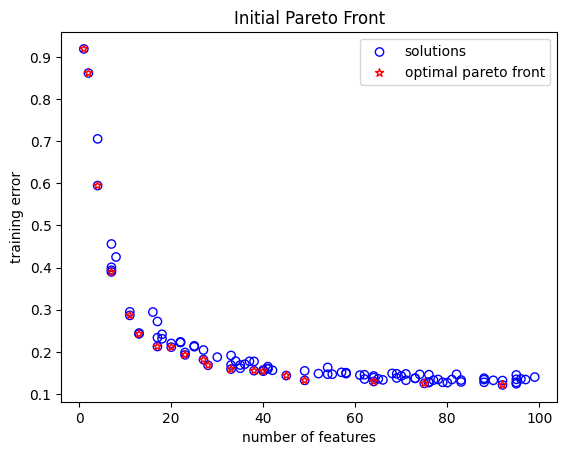

Total population members: 100
Pareto front members: 28


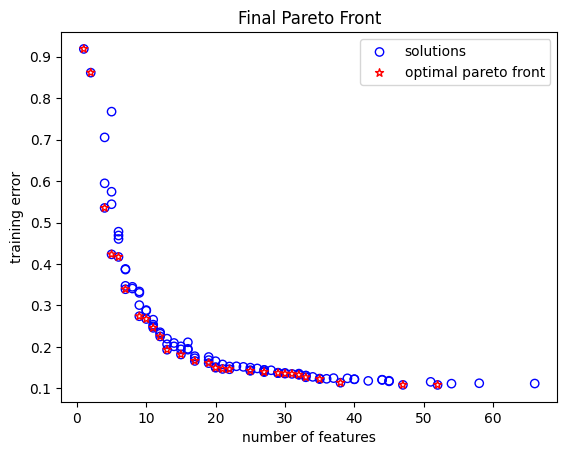

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.9187321900489495
classification error on test sets: 0.8807926274783703
solution 1:
number of selected features is: 2.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.8614807577066431
classification error on test sets: 0.7904391751776697
solution 2:
number of selected features is: 5.0
corresponding weights:  [0.         0.49862164 0.         0.         0.         0.
 0.11256594 0.41383822 0.         0.        ] ...
corresponding normalized weights:  [0.         0.2485519  0.         0.         0.         0.
 0.05611164 0.20628924 0.         0.        ] ...
classification err

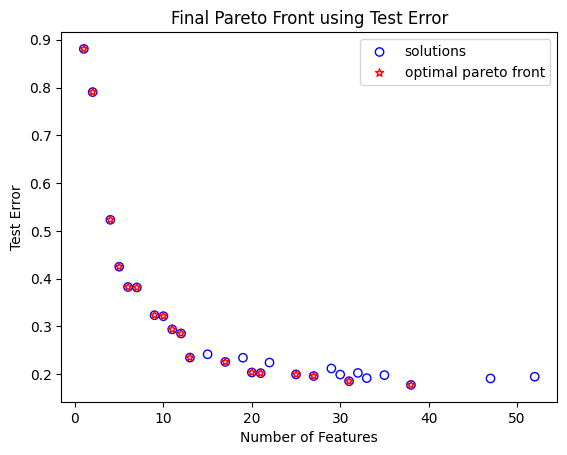

Final PF Results:  {0: {'num_selected_features': 1.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.049408816872707054, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.9187321900489495, 'test_error': 0.8807926274783703}, 1: {'num_selected_features': 2.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03030029515262605, 0.0, 0.0, 0.0

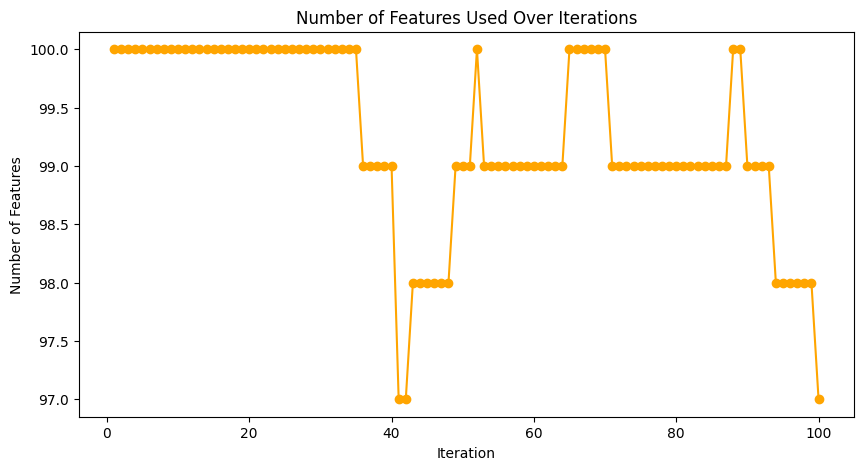

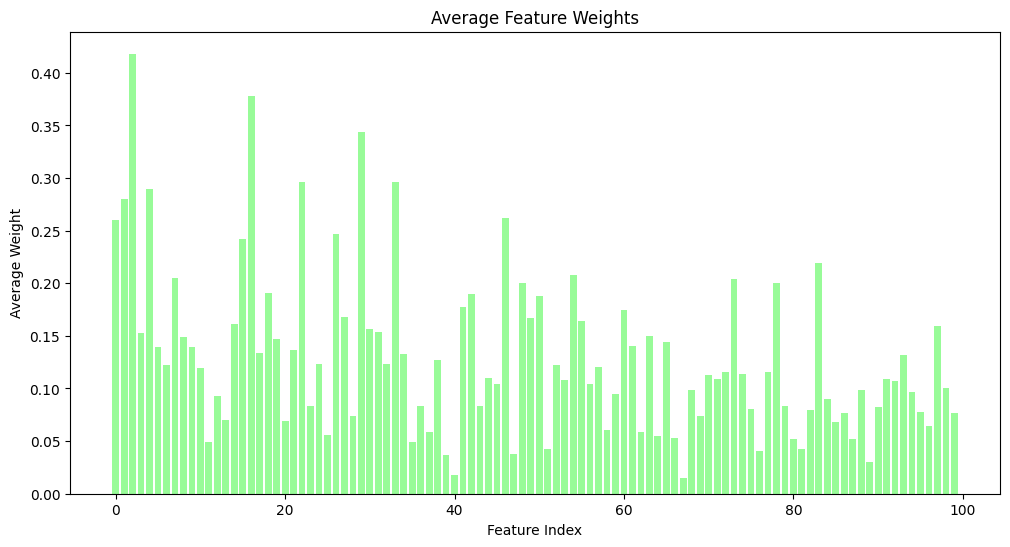

Total population members: 100
Pareto front members: 21


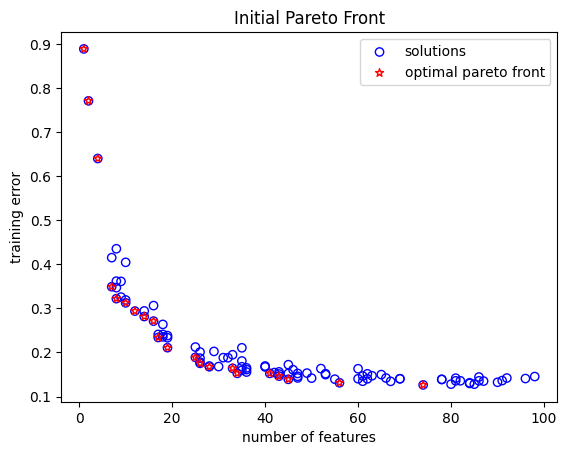

Total population members: 100
Pareto front members: 31


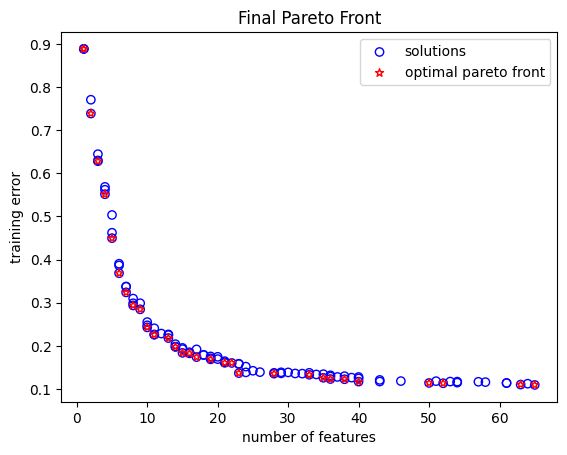

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.8884454016166456
classification error on test sets: 0.8655029507469052
solution 1:
number of selected features is: 1.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.8884454016166456
classification error on test sets: 0.8655029507469052
solution 2:
number of selected features is: 3.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.6280779518341697
classification error on test sets: 0.6799931112088239
solution 3:
number of selected features is: 19.0
corres

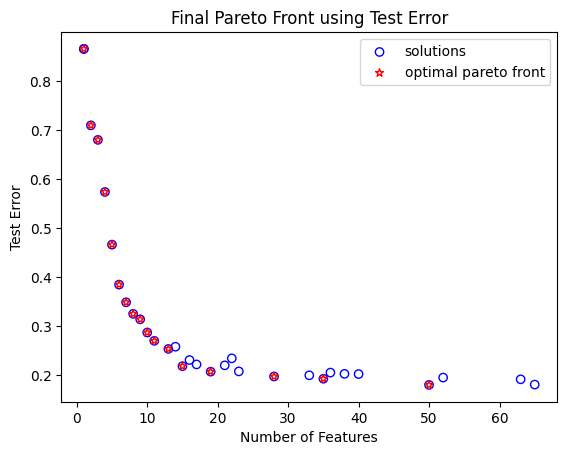

Final PF Results:  {0: {'num_selected_features': 1.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3316485216114534, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.8884454016166456, 'test_error': 0.8655029507469052}, 1: {'num_selected_features': 1.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

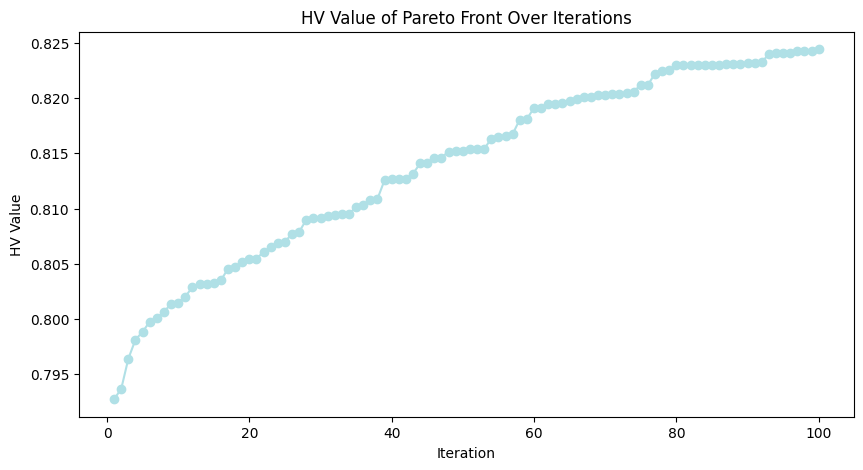

Total population members: 100
Pareto front members: 20


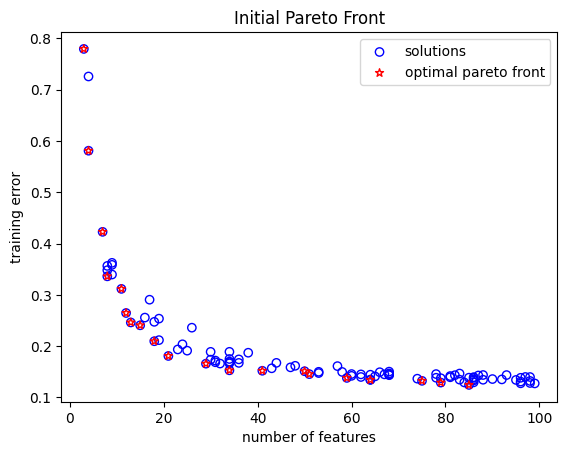

Total population members: 100
Pareto front members: 35


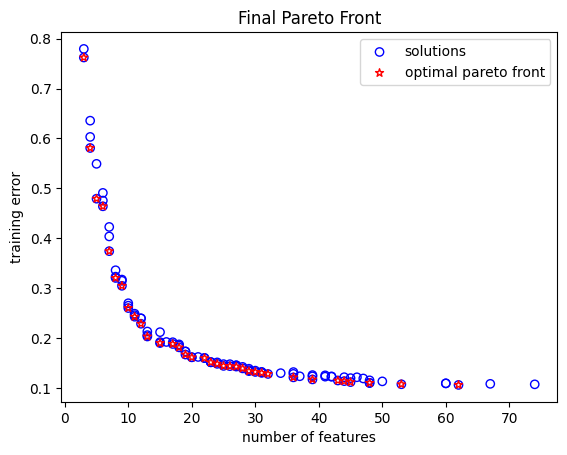

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 4.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.5809345406931552
classification error on test sets: 0.5968016442832565
solution 1:
number of selected features is: 13.0
corresponding weights:  [0.26687073 0.         0.         0.42519852 0.         0.50761071
 0.         0.         0.35120258 0.        ] ...
corresponding normalized weights:  [0.05297455 0.         0.         0.08440304 0.         0.10076208
 0.         0.         0.06971465 0.        ] ...
classification error on train sets: 0.2032196212419678
classification error on test sets: 0.24804101022422065
solution 2:
number of selected features is: 32.0
corresponding weights:  [0.         0.         0.         0.         0.7780907  0.95516543
 0.         0.69207462 0.76525963 0.   

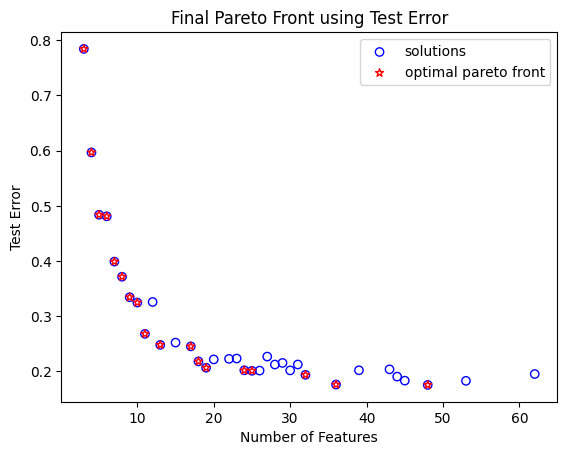

Final PF Results:  {0: {'num_selected_features': 4.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19631664448738634, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5745277353777808, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5067929848964793, 0.0, 0.0, 0.0, 0.09138395857182373, 0.0, 0.0], 'train_error': 0.5809345406931552, 'test_error': 0.5968016442832565}, 1: {'num_selected_features': 13.0, 'feature_weights': [0.26687072831174313, 0.0, 0.0, 0.4251985205988304, 0.0, 0.5076107107165675, 0.0, 0.0, 0.35120258068521554, 0.0, 0.08333624529364776, 0.0, 0.29260966096227253, 0.0, 0.0, 0.17708403667520992, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

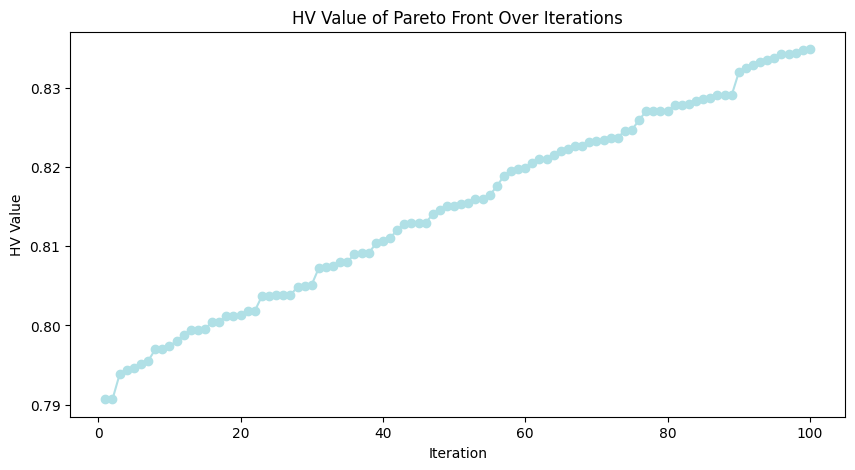

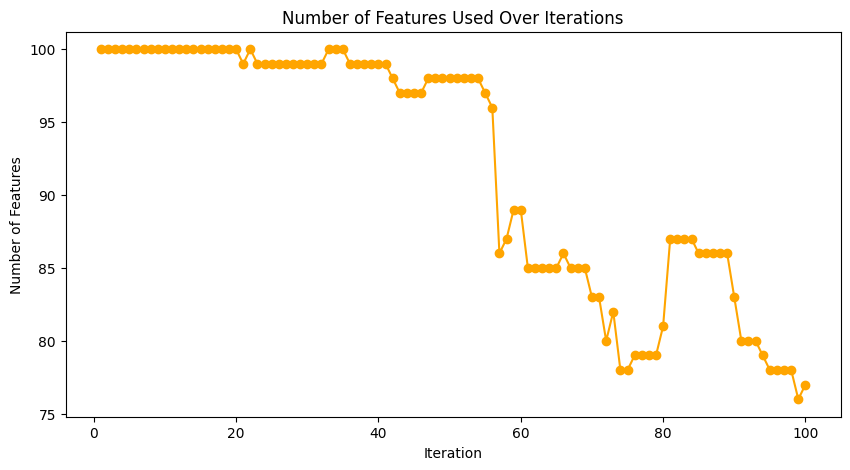

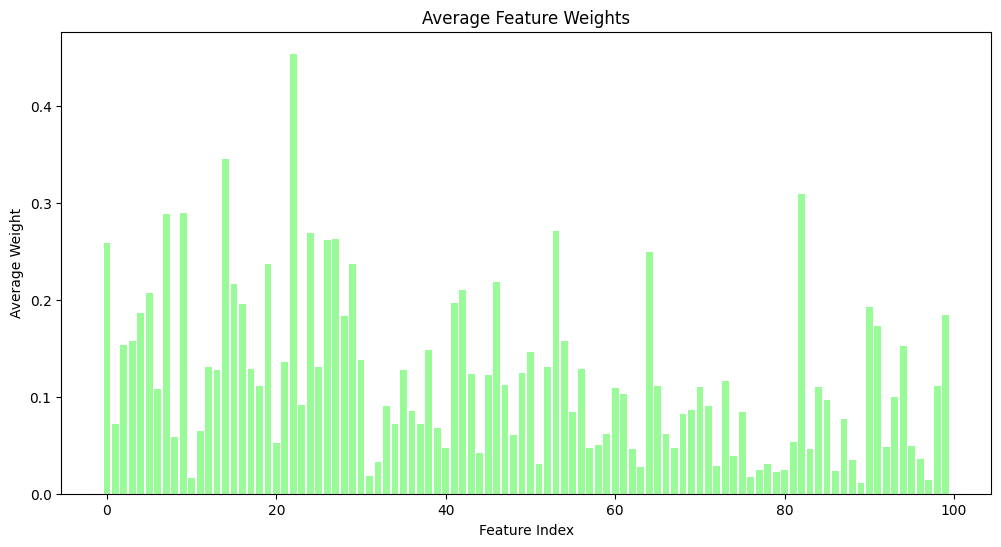

Total population members: 100
Pareto front members: 24


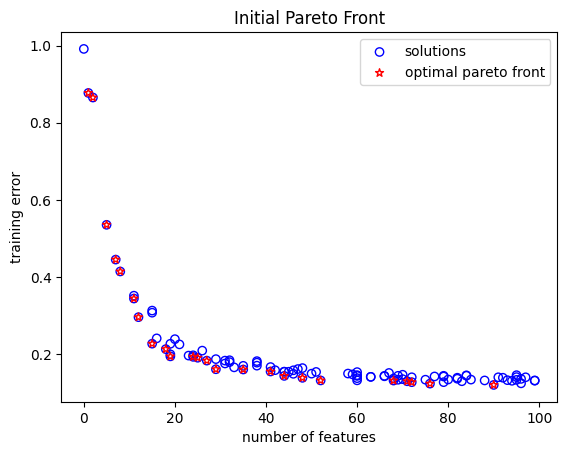

Total population members: 100
Pareto front members: 30


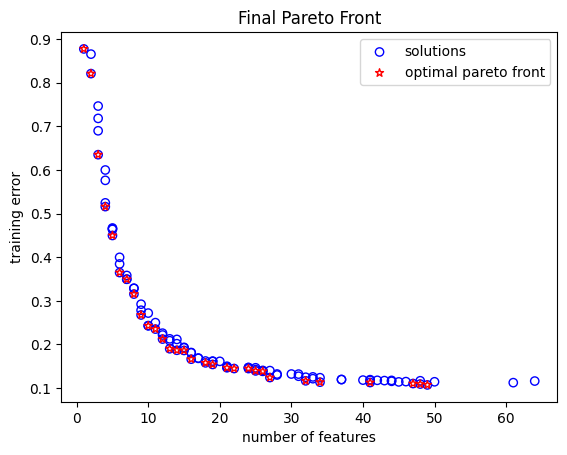

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.8772715766004864
classification error on test sets: 0.9089671018488644
solution 1:
number of selected features is: 15.0
corresponding weights:  [0.50816871 0.         0.         0.30039276 0.50504497 0.
 0.         0.         0.         0.        ] ...
corresponding normalized weights:  [0.08323741 0.         0.         0.04920396 0.08272574 0.
 0.         0.         0.         0.        ] ...
classification error on train sets: 0.18617208370529725
classification error on test sets: 0.2568460365359041
solution 2:
number of selected features is: 3.0
corresponding weights:  [0.53895917 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ] ...
corresponding 

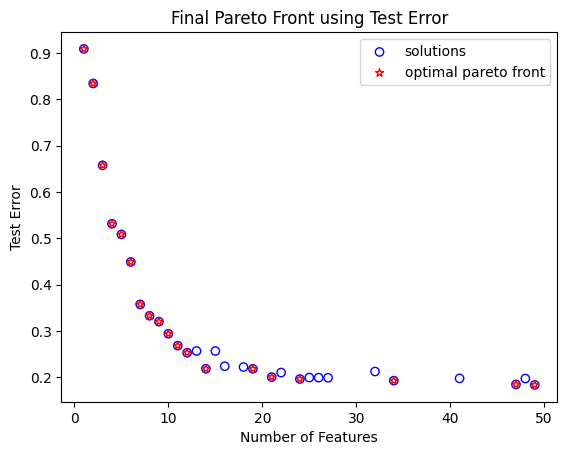

Final PF Results:  {0: {'num_selected_features': 1.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5495490702383713, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.8772715766004864, 'test_error': 0.9089671018488644}, 1: {'num_selected_features': 15.0, 'feature_weights': [0.5081687066729417, 0.0, 0.0, 0.30039276026108175, 0.5050449663894344, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4411960868551494, 0.0, 0.0, 0.0, 0.0, 0.2557165072772262, 0.0, 0.0, 0.0, 0.0, 0.551615811530291, 0.0, 0.0, 0.1306099905327555, 0.0, 0.0, 0.0, 0.2474428031761

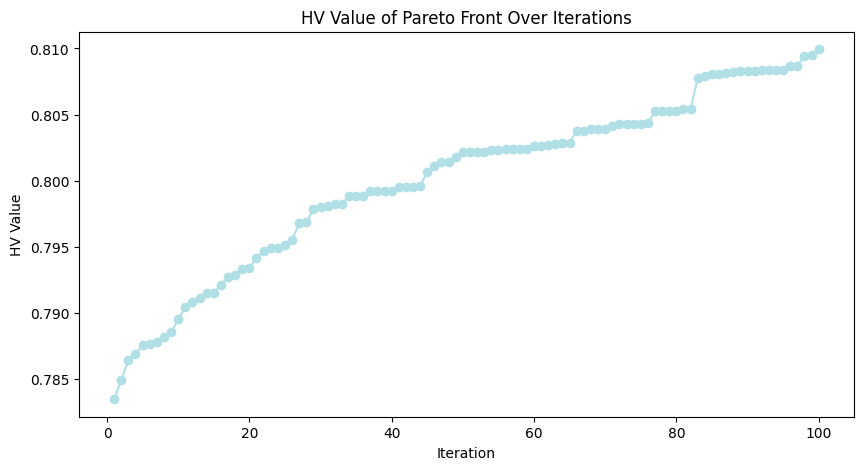

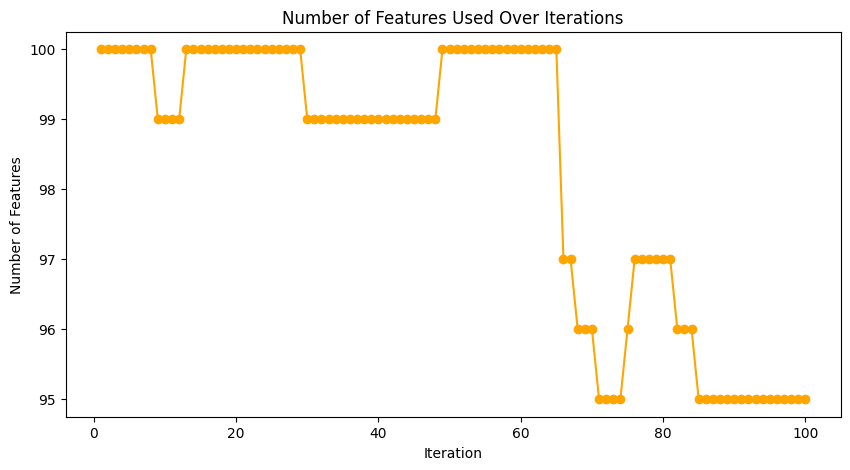

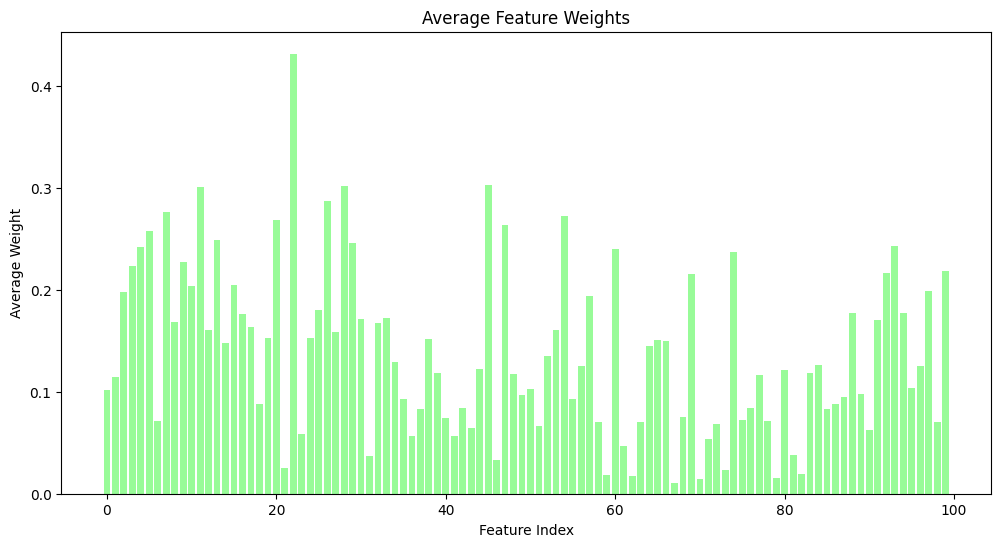

Total population members: 100
Pareto front members: 23


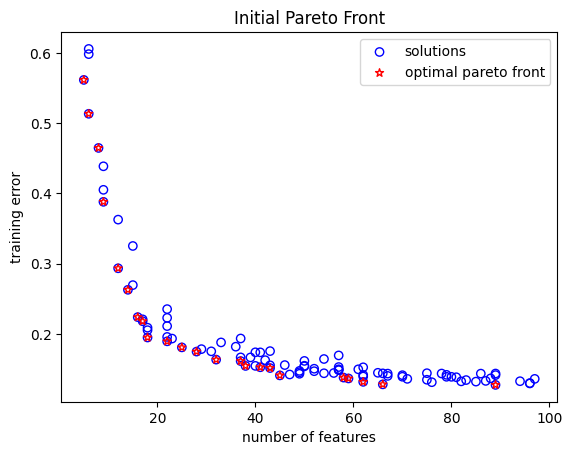

Total population members: 100
Pareto front members: 28


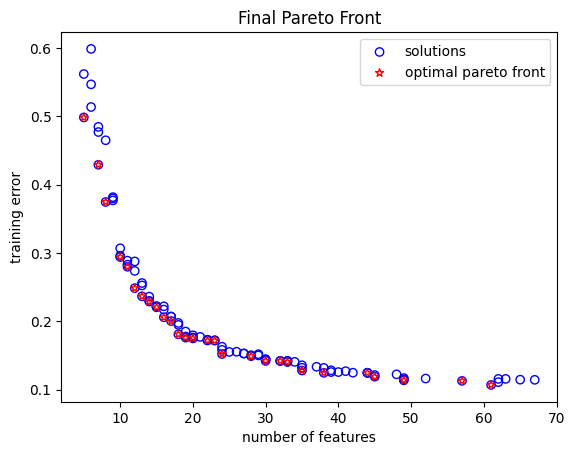

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 23.0
corresponding weights:  [0.         0.         0.         0.76931697 0.74041331 0.99827694
 0.06346452 0.73066803 0.         0.        ] ...
corresponding normalized weights:  [0.         0.         0.         0.06115707 0.05885937 0.07935831
 0.00504513 0.05808466 0.         0.        ] ...
classification error on train sets: 0.1716539231460703
classification error on test sets: 0.22179970159313833
solution 1:
number of selected features is: 7.0
corresponding weights:  [0.         0.80245279 0.         0.         0.         0.
 0.         0.         0.         0.        ] ...
corresponding normalized weights:  [0.         0.22026165 0.         0.         0.         0.
 0.         0.         0.         0.        ] ...
classification error on train sets: 0.42895826881187493
classification error on test sets: 0.45347488262682745
solution 2:
number of selected 

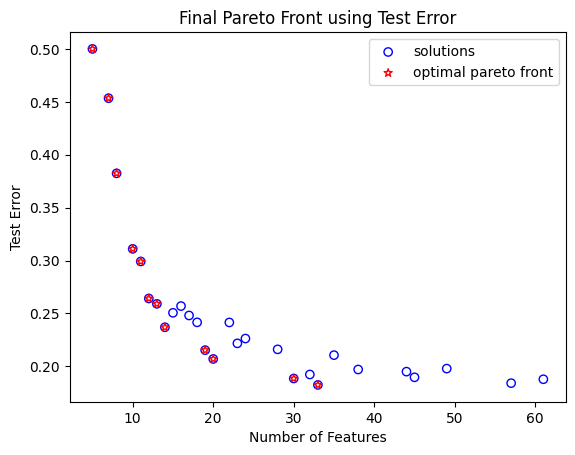

Final PF Results:  {0: {'num_selected_features': 23.0, 'feature_weights': [0.0, 0.0, 0.0, 0.7693169684415837, 0.7404133105450903, 0.9982769436283456, 0.06346451990065535, 0.7306680309618376, 0.0, 0.0, 0.8194956388665049, 0.748768495572861, 0.9536994890621954, 0.5301475402531973, 0.0, 0.0, 0.0, 0.544596613800395, 0.0, 0.0, 0.0, 0.0, 0.7100386180270801, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49961318736401605, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19832524358263598, 0.0, 0.0, 0.6600776982612584, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37551883878797143, 0.0, 0.0, 0.7569663446137561, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03423933622221371, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5529673375907719, 0.0, 0.0, 0.10447590121449185, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.48360910910321964, 0.0, 0.13457194235697173, 0.9533805736553905, 0.0, 0.0, 0.0, 0.21673082696533824, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.1716539231460703, 'test_error': 0.22179970159313833}, 1

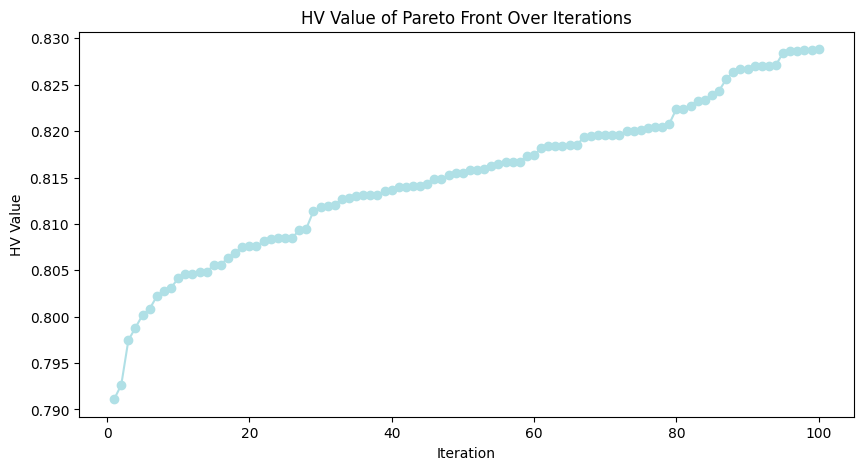

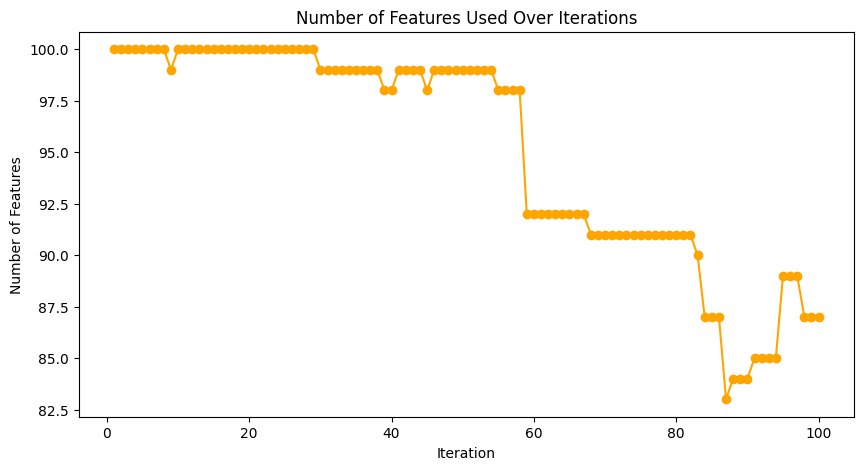

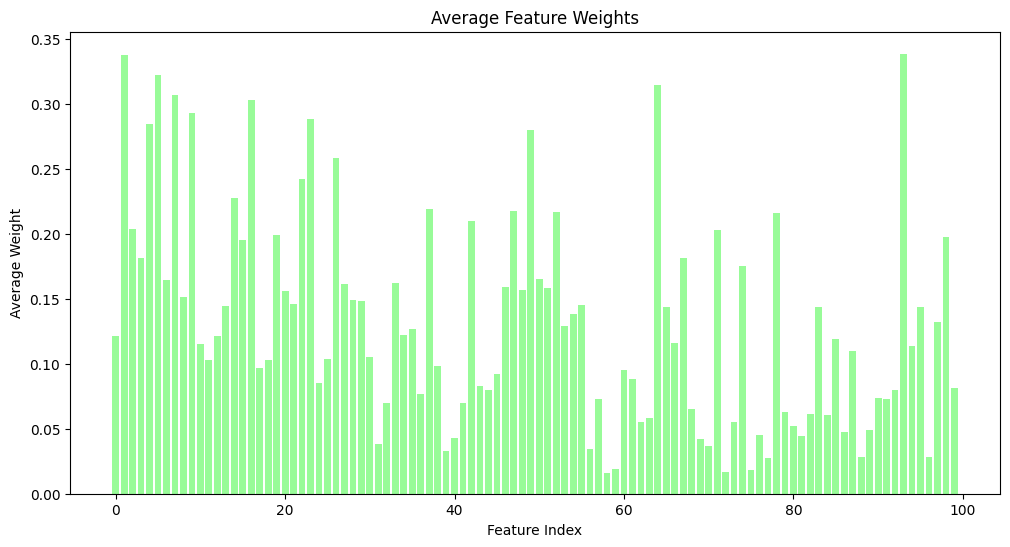

Total population members: 100
Pareto front members: 23


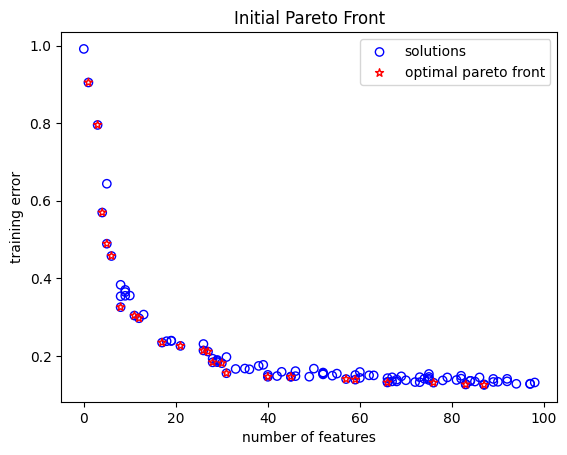

Total population members: 100
Pareto front members: 30


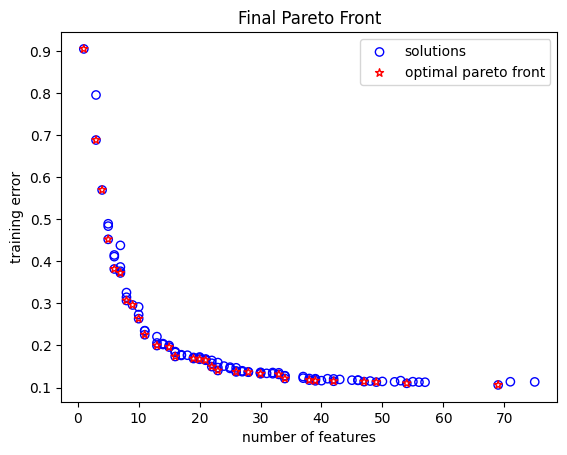

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 4.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.5695958214439505
classification error on test sets: 0.5832928656783364
solution 1:
number of selected features is: 1.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.9047960892674531
classification error on test sets: 0.8763091752673552
solution 2:
number of selected features is: 5.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.4522434313258994
classification error on test sets: 0.46496926481646483
solution 3:
number of selected features is: 8.0
corres

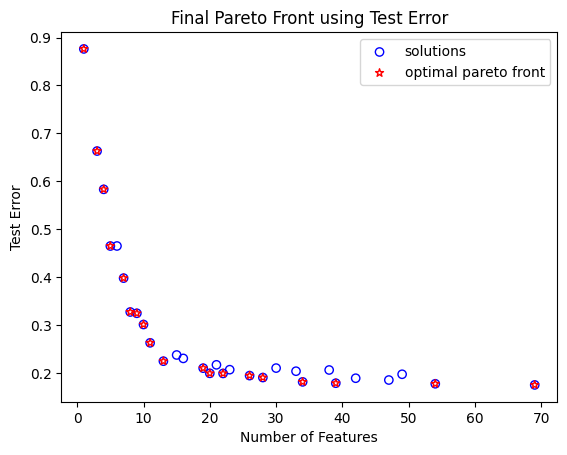

Final PF Results:  {0: {'num_selected_features': 4.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2671417586897414, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6212159073284597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.89023444306401, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8064018075456103, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.5695958214439505, 'test_error': 0.5832928656783364}, 1: {'num_selected_features': 1.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7527257341886218, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

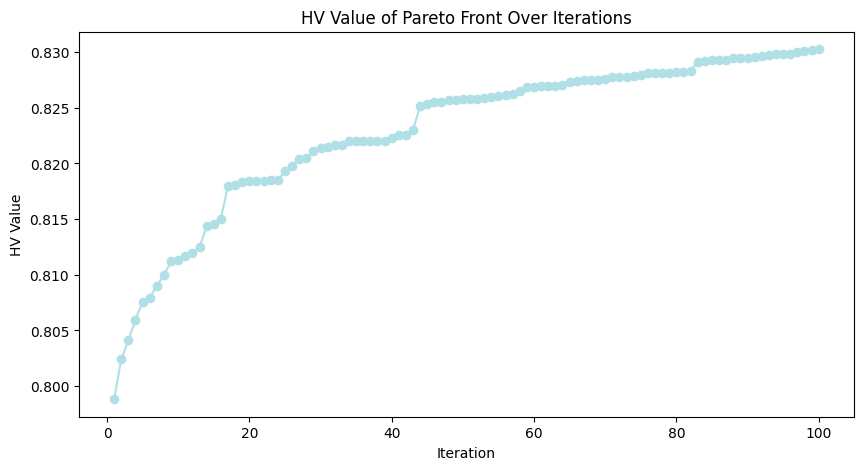

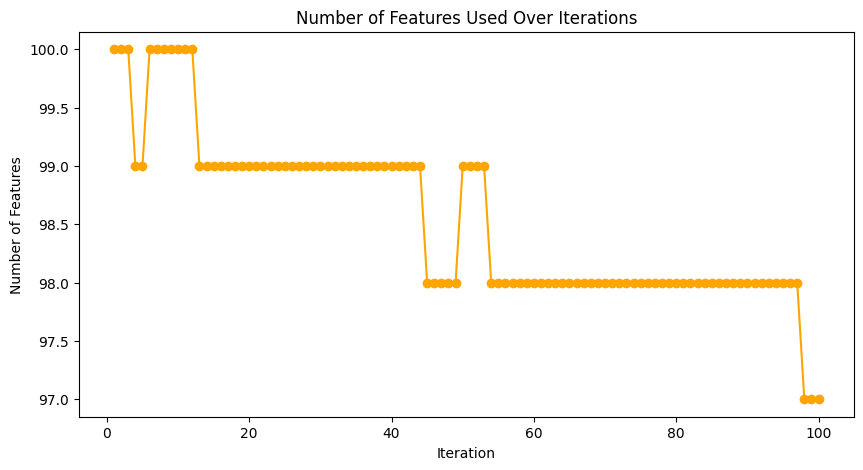

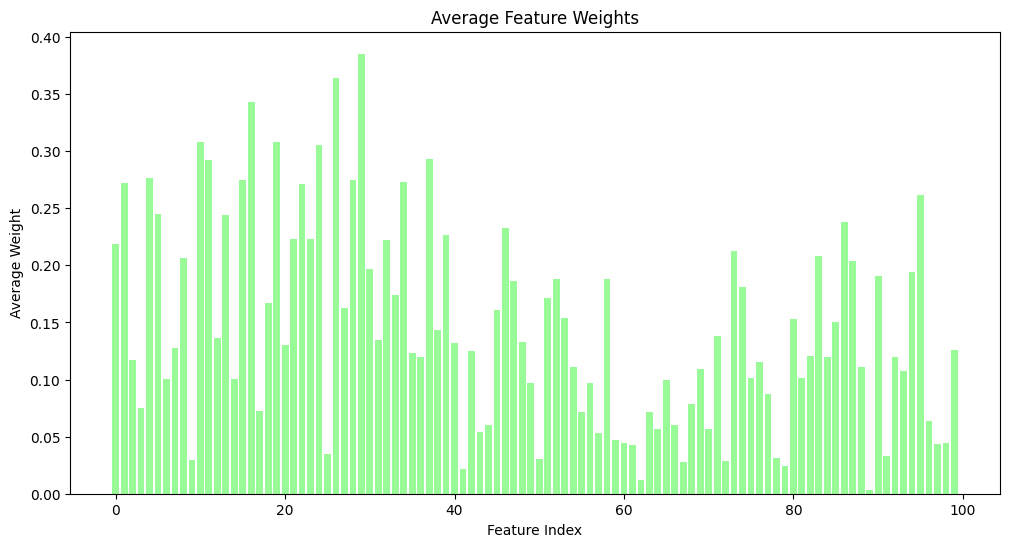

Total population members: 100
Pareto front members: 21


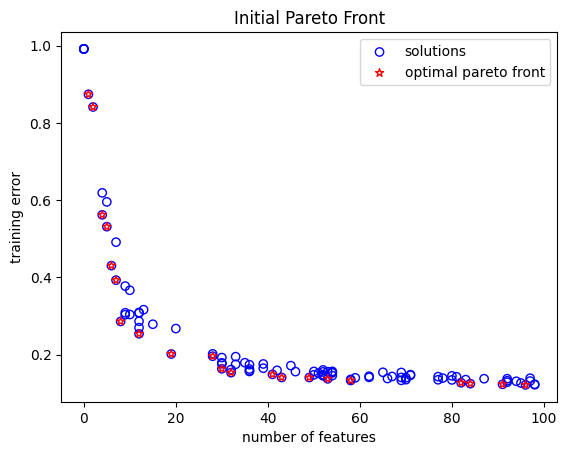

Total population members: 100
Pareto front members: 35


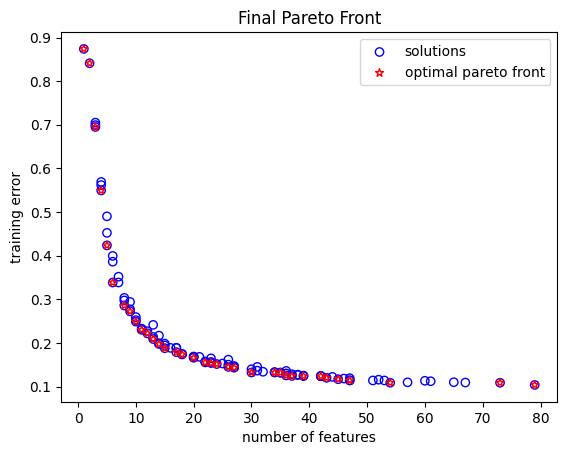

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 8.0
corresponding weights:  [0.         0.59138164 0.         0.         0.         0.
 0.         0.         0.         0.        ] ...
corresponding normalized weights:  [0.        0.1347946 0.        0.        0.        0.        0.
 0.        0.        0.       ] ...
classification error on train sets: 0.2858159694628025
classification error on test sets: 0.34417823992292096
solution 1:
number of selected features is: 9.0
corresponding weights:  [0.         0.59138164 0.         0.         0.         0.
 0.         0.         0.         0.        ] ...
corresponding normalized weights:  [0.         0.13985694 0.         0.         0.         0.
 0.         0.         0.         0.        ] ...
classification error on train sets: 0.27226811446998866
classification error on test sets: 0.3104131363089795
solution 2:
number of selected features is: 5.0
correspond

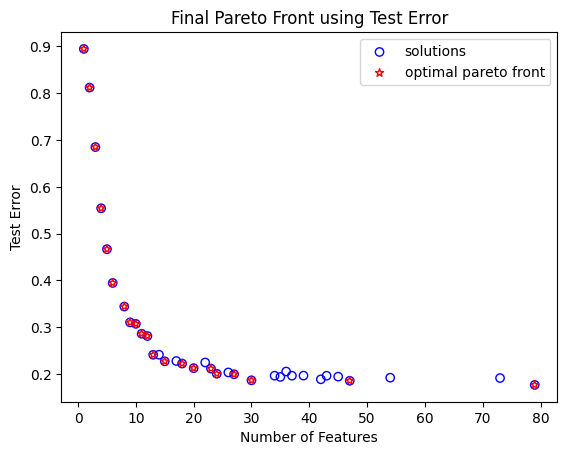

Final PF Results:  {0: {'num_selected_features': 8.0, 'feature_weights': [0.0, 0.5913816393896277, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7602754787977891, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5983278010774523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.41247947312673044, 0.0, 0.0, 0.0, 0.4989717102374805, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3424904258807621, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1847095343462665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9986437892703616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.2858159694628025, 'test_error': 0.34417823992292096}, 1: {'num_selected_features': 9.0, 'feature_weights': [0.0, 0.5913816393896277, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6419991744415876, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5138557628278904, 0.0, 0.0, 0.231603988351

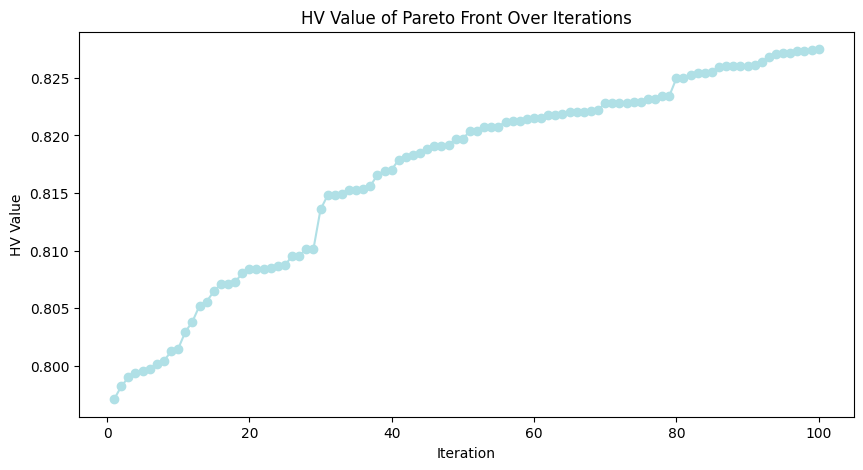

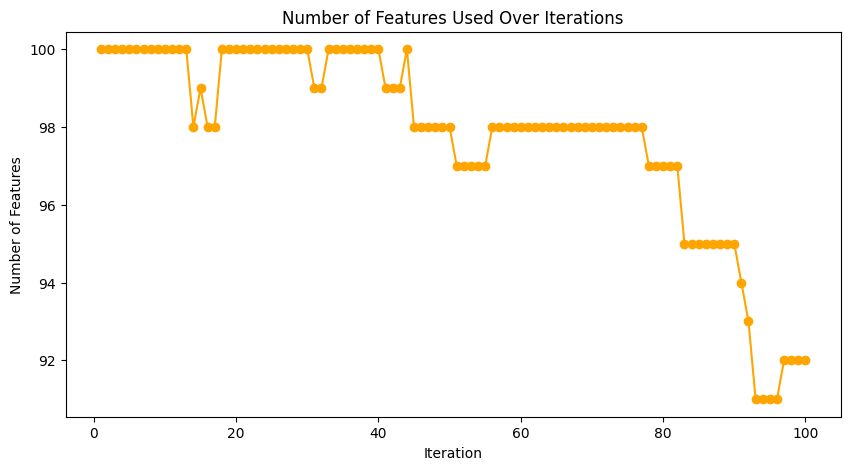

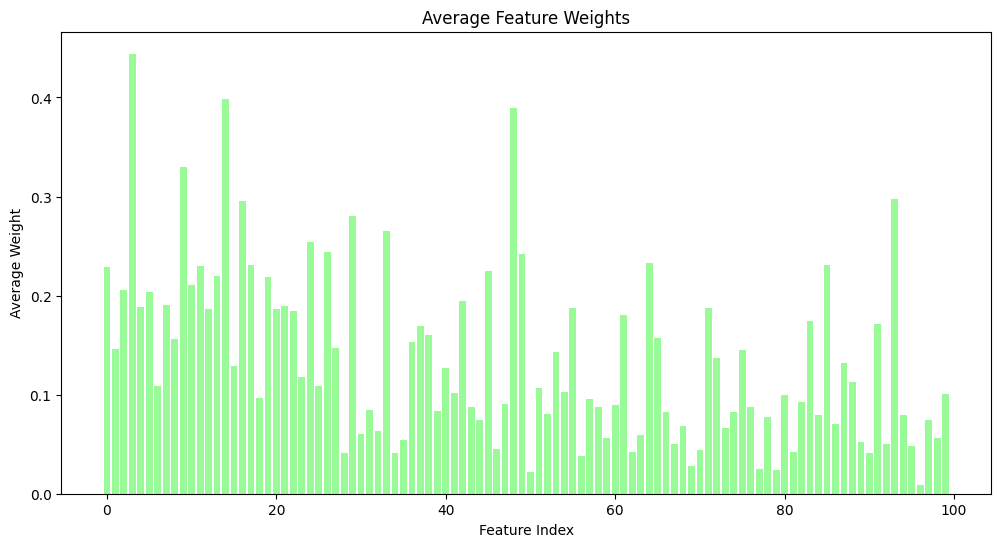

Total population members: 100
Pareto front members: 20


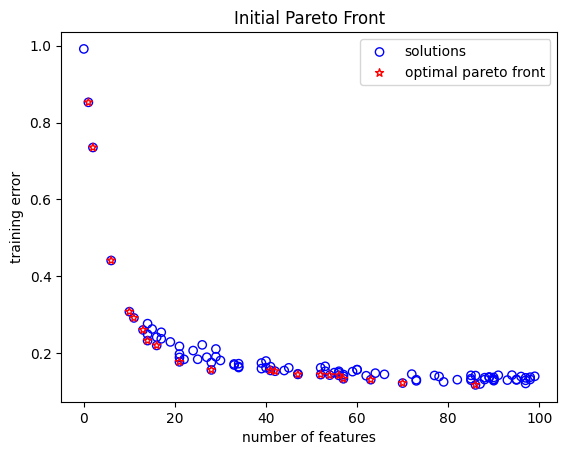

Total population members: 100
Pareto front members: 29


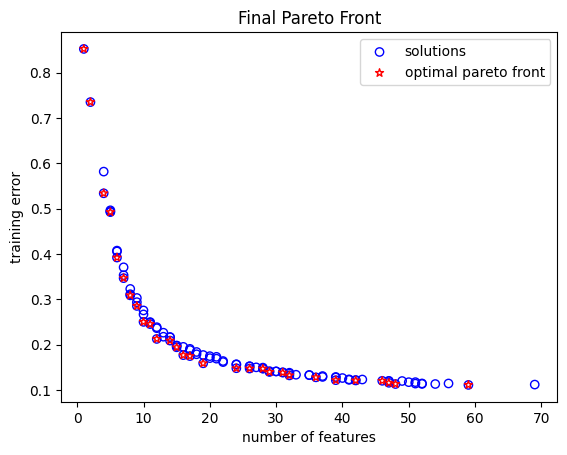

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 2.0
corresponding weights:  [0.32547795 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ] ...
corresponding normalized weights:  [0.47329681 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ] ...
classification error on train sets: 0.7351634209761934
classification error on test sets: 0.7528343043791249
solution 1:
number of selected features is: 7.0
corresponding weights:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.57000649] ...
corresponding normalized weights:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.18425022] ...
classification error on train sets: 0.346543041310193
classification error on test sets: 0.3449849923124505
solution 2:
number of selected features is: 1.0
corr

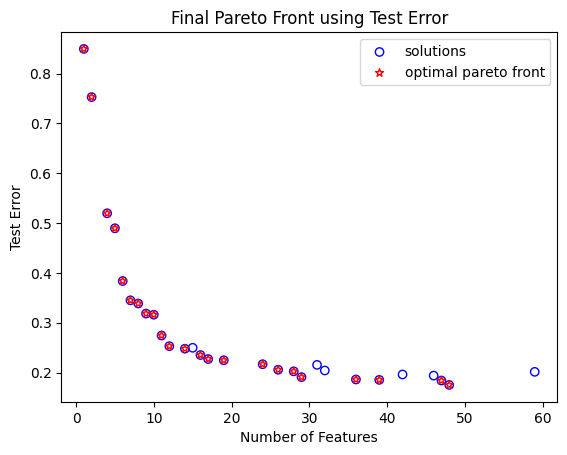

Final PF Results:  {0: {'num_selected_features': 2.0, 'feature_weights': [0.32547794902942556, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36220458152364676, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.7351634209761934, 'test_error': 0.7528343043791249}, 1: {'num_selected_features': 7.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5700064879678411, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.41669770645149407, 0.0, 0.0, 0.0, 0.28165203241754605, 0.0, 0.5749392582090235, 0.3270689598416304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

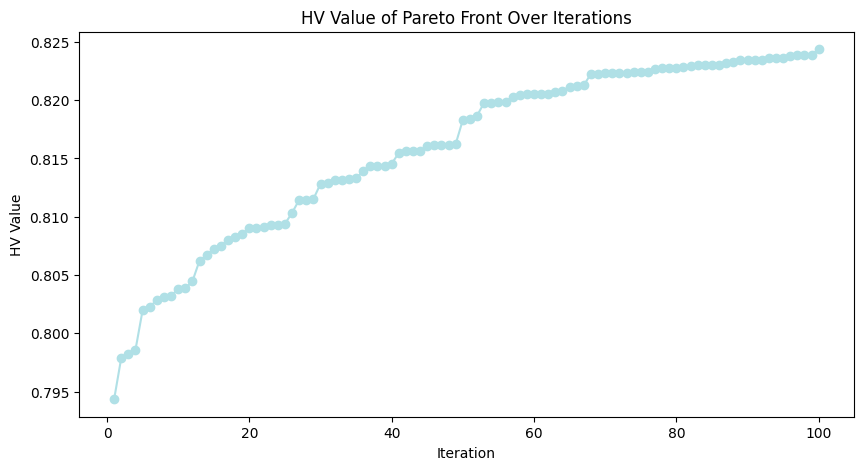

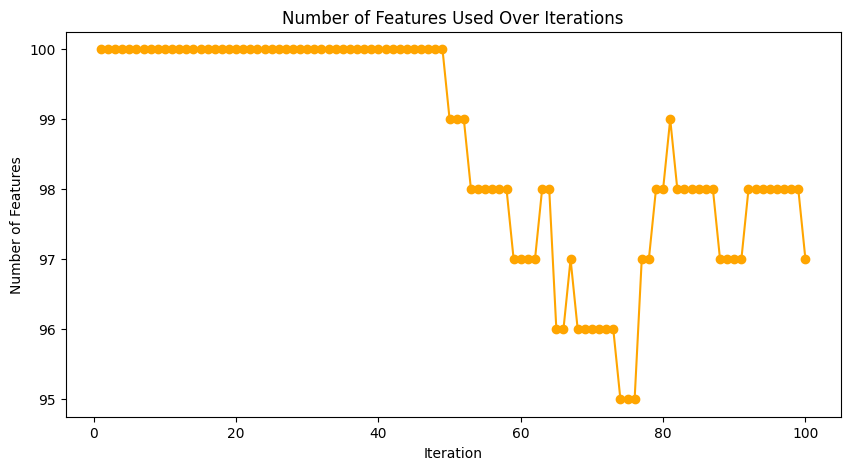

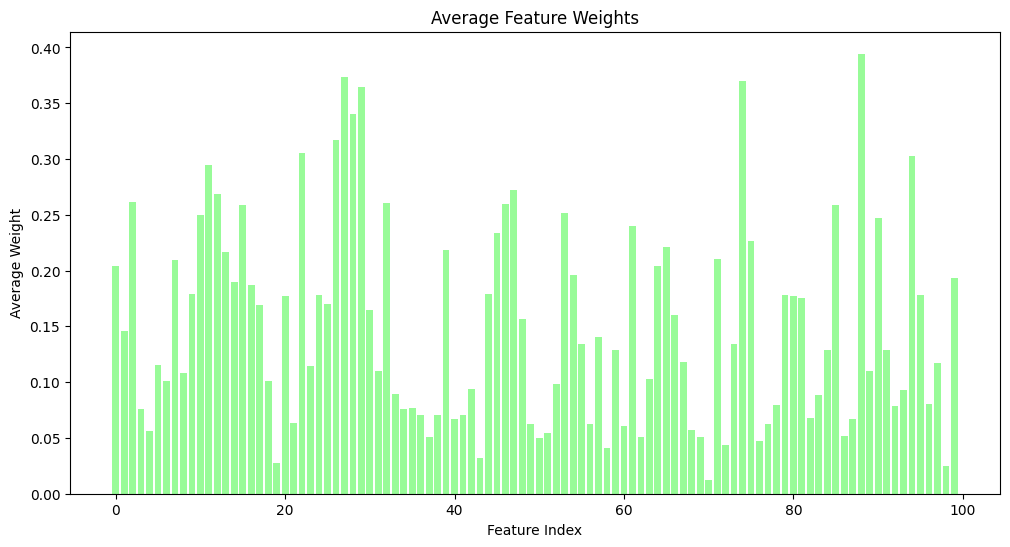

Total population members: 100
Pareto front members: 15


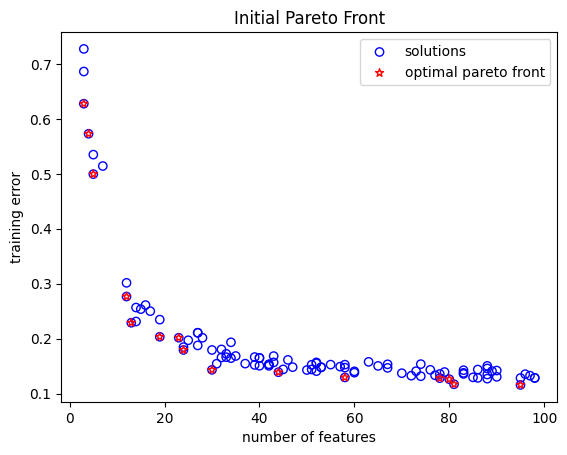

Total population members: 100
Pareto front members: 34


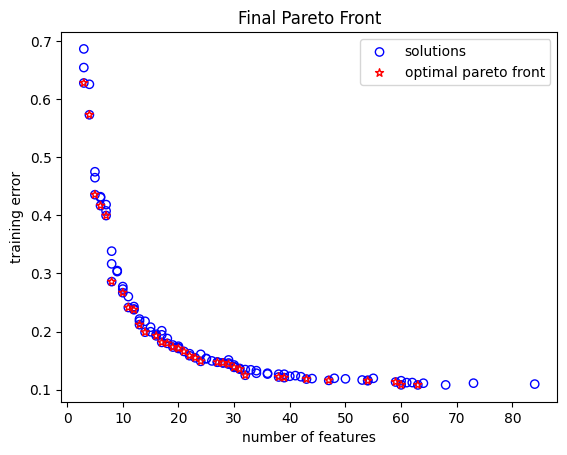

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 4.0
corresponding weights:  [0.         0.         0.         0.         0.         0.
 0.66698933 0.         0.         0.        ] ...
corresponding normalized weights:  [0.         0.         0.         0.         0.         0.
 0.27232298 0.         0.         0.        ] ...
classification error on train sets: 0.5730153043491133
classification error on test sets: 0.5654600076434875
solution 1:
number of selected features is: 3.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.6277606236479214
classification error on test sets: 0.6534052194133557
solution 2:
number of selected features is: 7.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification err

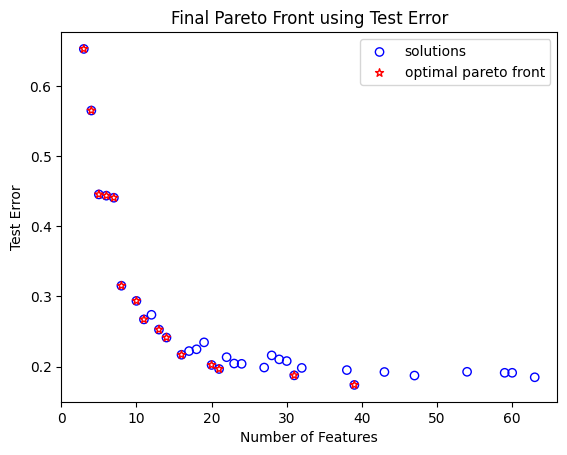

Final PF Results:  {0: {'num_selected_features': 4.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6669893348581842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9909394468126906, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3887688551725759, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4025607629040703, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.5730153043491133, 'test_error': 0.5654600076434875}, 1: {'num_selected_features': 3.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7117639509528384, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8809413949648706, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

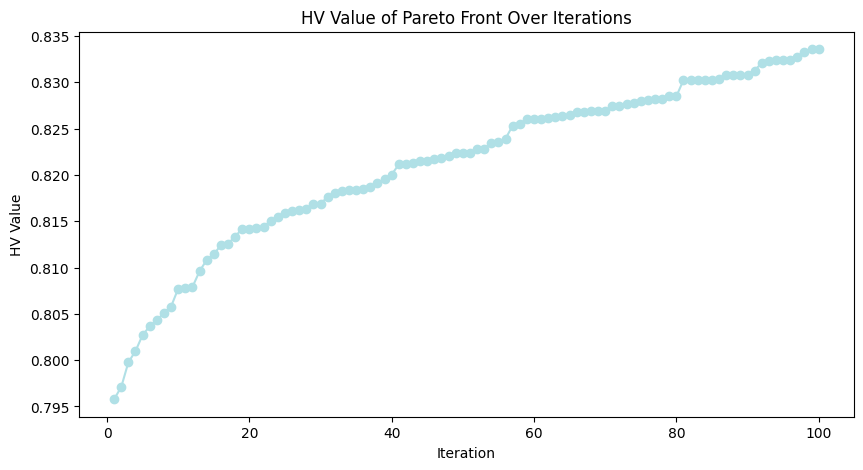

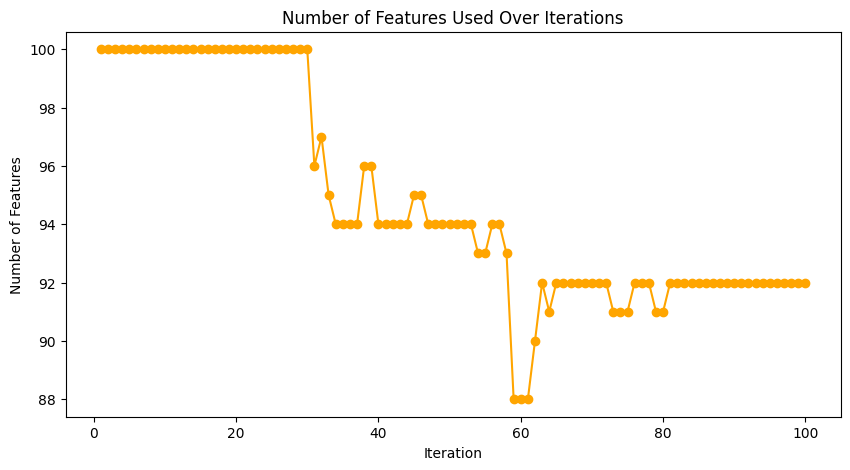

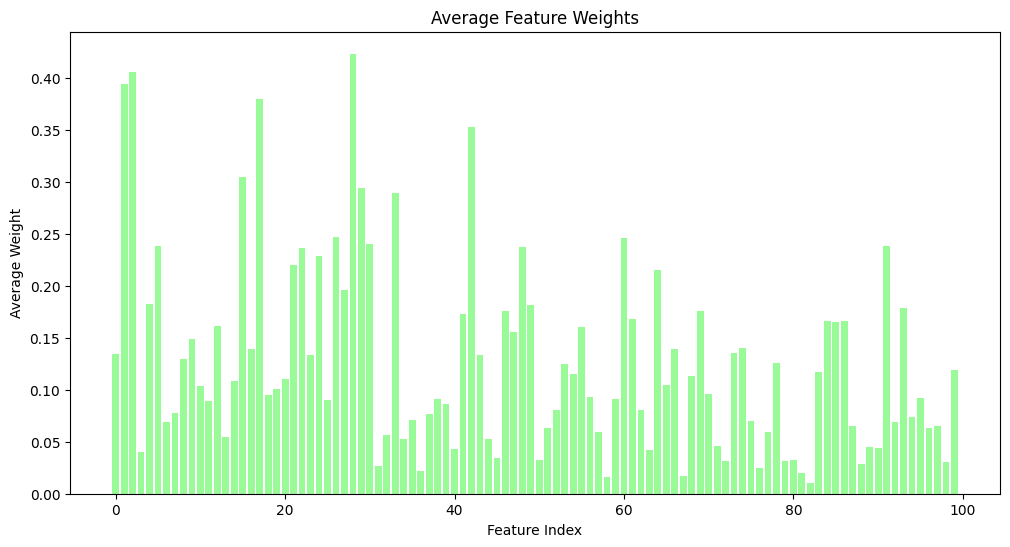

Total population members: 100
Pareto front members: 23


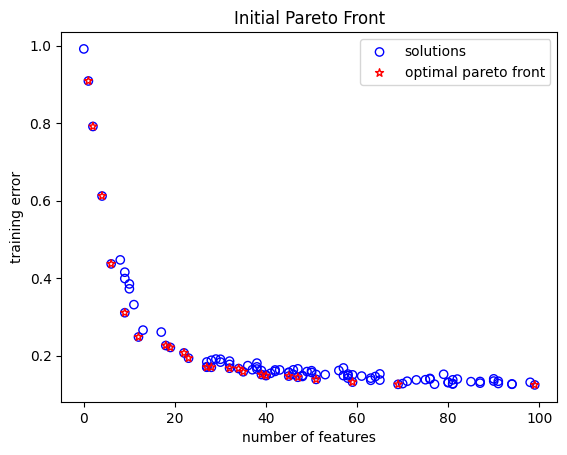

Total population members: 100
Pareto front members: 28


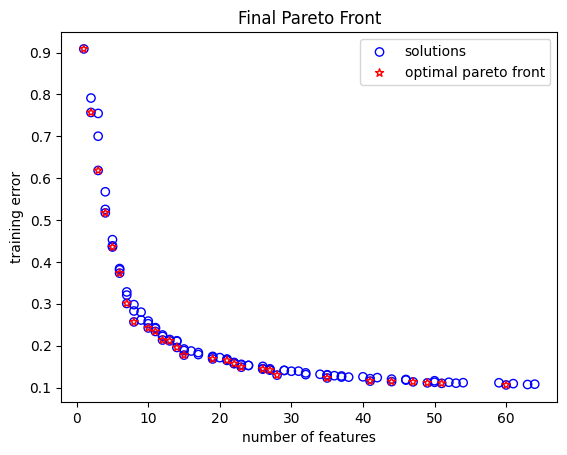

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 14.0
corresponding weights:  [0.         0.27246354 0.24163842 0.         0.         0.
 0.         0.         0.         0.        ] ...
corresponding normalized weights:  [0.         0.07385561 0.06549997 0.         0.         0.
 0.         0.         0.         0.        ] ...
classification error on train sets: 0.19573200852876282
classification error on test sets: 0.23309644666078877
solution 1:
number of selected features is: 1.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.9086361245815112
classification error on test sets: 0.9078139885775189
solution 2:
number of selected features is: 15.0
corresponding weights:  [0.76528113 0.63655401 0.54327789 0.         0.         0.
 0.         0.         0.         0.35718605] ...
correspondin

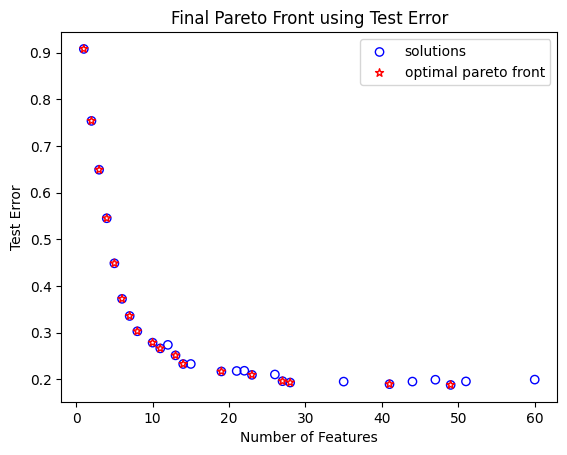

Final PF Results:  {0: {'num_selected_features': 14.0, 'feature_weights': [0.0, 0.27246354487484953, 0.2416384189446042, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.272851359839051, 0.0, 0.0, 0.0, 0.3294552068159788, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2486629907406772, 0.0, 0.0, 0.0, 0.1702519233934128, 0.0, 0.11413710320537784, 0.0, 0.0, 0.0, 0.3911232229416724, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.30371849748154695, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37301597830779654, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08293681458519098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3646484155823817, 0.4036000470081994, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12063456455340554, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.19573200852876282, 'test_error': 0.23309644666078877}, 1: {'num_selected_features': 1.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [63]:
# Read top 100 features
top_100 = pd.read_csv("Top_NSGA2_Features.csv").head(100)
print(top_100)
# Read validation data
validation_path = "KimiaNet_Data/kimianet_validation_data_averaged_feature_vectors.csv"
validation = pd.read_csv(validation_path)
dclass = validation.columns[0]
x = validation.drop(columns=[dclass])
y = validation[dclass]
featureNames = []
for i in top_100['Feature'].tolist():
    featureNames.append(x.columns[i-1]) #featureNames has feature names from 1-1024, not indices; so, to access feature x, we need to go to index i-1
print(featureNames)
x = x[featureNames]
# Read test data
test_path = "KimiaNet_Data/kimianet_test_data_averaged_feature_vectors.csv"
test = pd.read_csv(test_path)
dclass = test.columns[0]
xtest = test.drop(columns=[dclass])
ytest = test[dclass]
featureNames = []
for i in top_100['Feature'].tolist():
    featureNames.append(xtest.columns[i-1]) 
xtest = xtest[featureNames]

# Run GDE3 algorithm 10 times
epsilon = 0.01
total_features = x.shape[1] 
popsize=100
print("TOTAL NUMBER OF FEATURES: ", total_features)
for run in range(10):
    print("*"*50, f"RUN {run+1}", "*"*50)
    dataset_name = f"RUN {run+1}: GDE3 Kimianet Feature Weighting"

    custom_population = generate_individuals(total_features, epsilon, popsize)
    pop = Population.new("X", custom_population)

    problem = MyProblem(x,y,epsilon)
    Evaluator().eval(problem, pop) # evaluate initial population
    algorithm = GDE3(pop_size=popsize,
                    variant="DE/rand/1/bin", # selection = random, crossover = binary
                    CR=0.5, # crossover parameter [0,1]
                    F=(0.0, 0.9), # scale factor or mutation parameter (0,2]
                    sampling = pop
                    )
    res = minimize(problem,
                    algorithm,
                    ("n_gen", 100),
                    verbose=True, # prints results if true
                    save_history=True
                    )
    '''
    ALGORITHM DESCRIPTION
    The algorithm generates new solutions for the next generation by iteratively selecting each solution in the current generation (called the target vector) and performing the following steps:
    1. Selecting two random solutions from the current generation to calculate a difference vector.
    2. Scaling the difference vector by a factor F.
    3. Adding the scaled difference vector to a third random solution (called the base vector) to form a mutant vector, which becomes a candidate solution.
    4. Performing crossover between the target vector (current solution) and the mutant vector to form a trial vector.
    5. Evaluating the trial vector to determine if it should replace the target vector in the next generation (based on its fitness/performance).
    This process is repeated for each solution in the current generation.
    PARAMS DESCRIPTION
    pop_size: number of individuals in each generation
    variant: format of DE strategy as "DE/selection/n/crossover", where
        1. selection = how the base vector is selected when forming the mutant vector 
            (e.g., rand = base vector is chose randomly, best = best performing solution in current generation is always chosen as the base vector)
        2. n = number of difference vectors used for mutation 
            (e.g., 1 = one difference vector is used)
        3. crossover = how crossover is performed between the target vector and mutant vector to form the trial vector
            (e.g., bin = each component (i.e., each feature weight) of the offspring is selected either from the mutant vector or from the current parent vector based on probability CR)
    CR: crossover probability of the trial vector inheriting a component from the mutant vector (higher CR = more likely to inherit mutant component)
    F: scaling factor of difference vector; higher value leads to larger mutations and more exploration, lower value leads to smaller mutations and more exploitation (fine-tuning)
        (e.g., (0.0-0.9) means a random scaling factor will be chosen between 0 - 0.9 for each candidate solution in the next generation)
    sampling: used to manually input an initial generation
    '''

    final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training = visualize(res, x, y, xtest, ytest, epsilon)
    store_results(dataset_name, final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training, epsilon, featureNames)

TOTAL NUMBER OF FEATURES:  50
************************************************** RUN 1 **************************************************
INDIVIDUAL 1, 20 features: [0.4431918  0.         0.         0.37536978 0.         0.
 0.         0.         0.         0.95230069]...
INDIVIDUAL 2, 26 features: [0.         0.         0.         0.46919765 0.63172907 0.97303935
 0.76916288 0.         0.         0.        ]...
INDIVIDUAL 3, 7 features: [0.         0.92834013 0.         0.         0.         0.
 0.         0.         0.         0.03611202]...
INDIVIDUAL 4, 14 features: [0.3206698  0.         0.         0.61905619 0.         0.
 0.91395893 0.         0.         0.9282299 ]...
INDIVIDUAL 5, 40 features: [0.         0.05433088 0.07810599 0.18226173 0.68724512 0.20658704
 0.1247691  0.36935457 0.09637903 0.        ]...
INDIVIDUAL 6, 42 features: [0.27486608 0.51859888 0.         0.64596046 0.96469981 0.62129941
 0.78058002 0.         0.91511908 0.        ]...
INDIVIDUAL 7, 32 features: [0

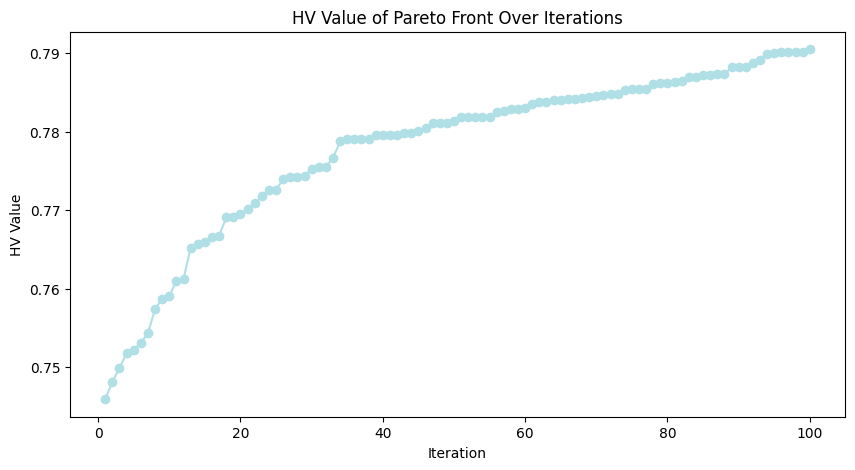

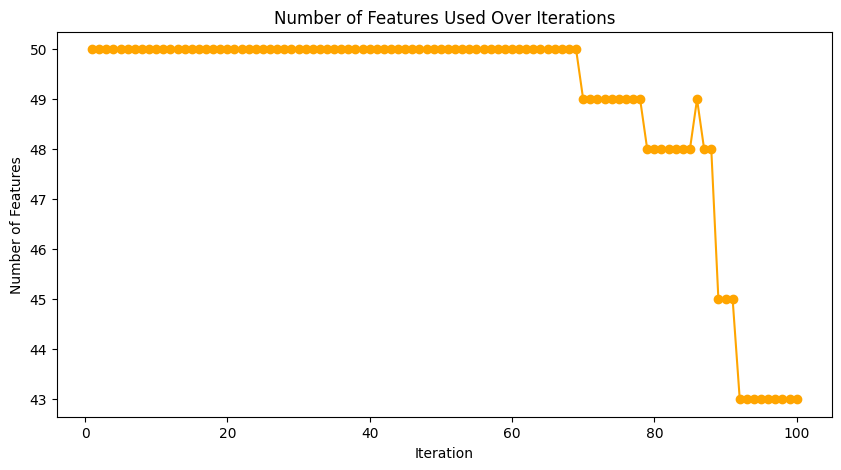

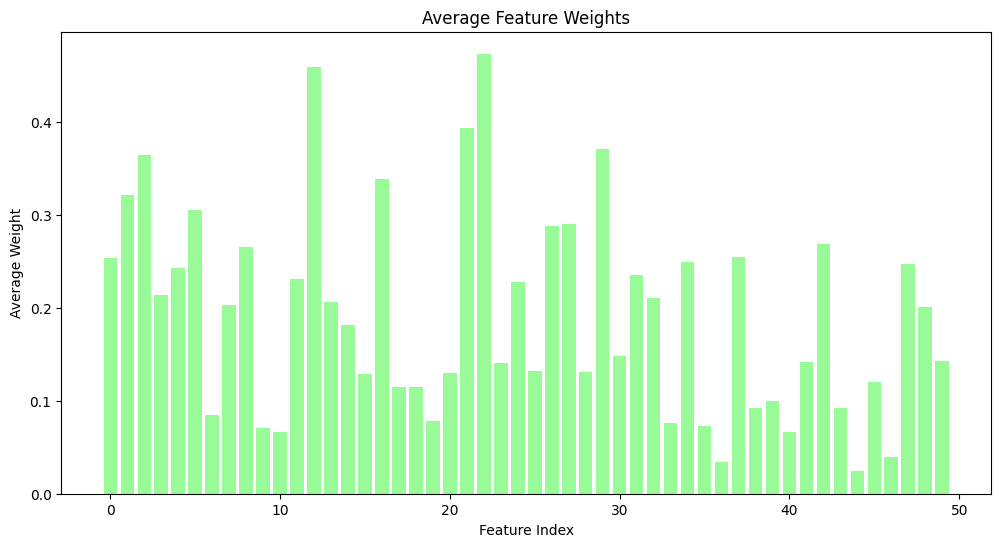

Total population members: 100
Pareto front members: 20


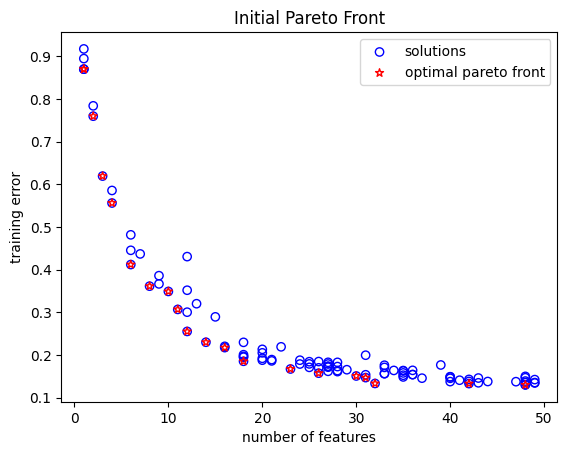

Total population members: 100
Pareto front members: 22


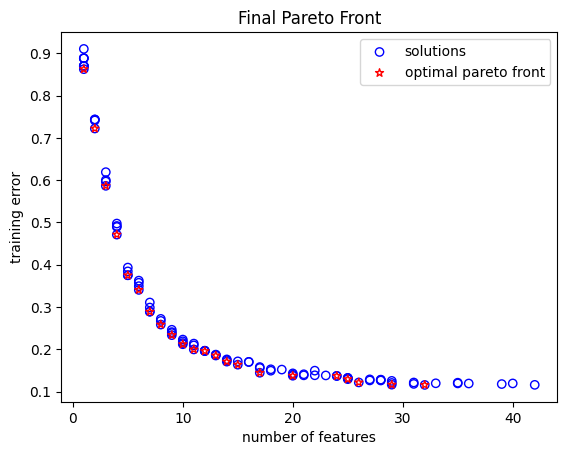

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 3.0
corresponding weights:  [0.         0.1797339  0.         0.         0.         0.11236419
 0.         0.         0.         0.        ] ...
corresponding normalized weights:  [0.         0.46520905 0.         0.         0.         0.2908346
 0.         0.         0.         0.        ] ...
classification error on train sets: 0.586753750743631
classification error on test sets: 0.6273493894464848
solution 1:
number of selected features is: 1.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.8628120538158484
classification error on test sets: 0.8898127569138303
solution 2:
number of selected features is: 6.0
corresponding weights:  [0.59313512 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ] ...
co

Final PF Results:  {0: {'num_selected_features': 3.0, 'feature_weights': [0.0, 0.17973389980882112, 0.0, 0.0, 0.0, 0.11236418574042689, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09425273783415943, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.586753750743631, 'test_error': 0.6273493894464848}, 1: {'num_selected_features': 1.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09425273783415943, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.8628120538158484, 'test_error': 0.8898127569138303}, 2: {'num_selected_features': 6.0, 'feature_weights': [0.593135119110267, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5990432264674037, 0.0, 0.0, 0.0, 0.0,

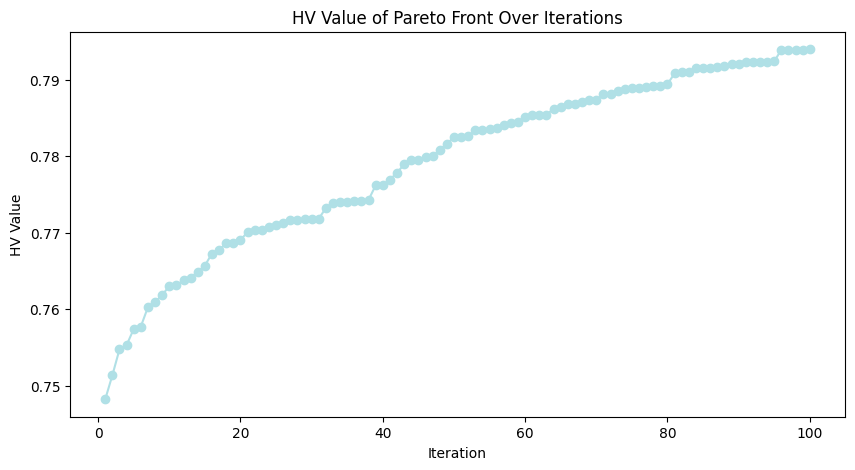

Total population members: 100
Pareto front members: 20


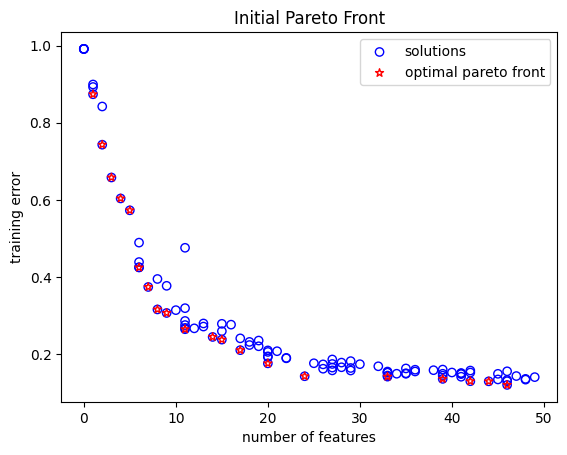

Total population members: 100
Pareto front members: 27


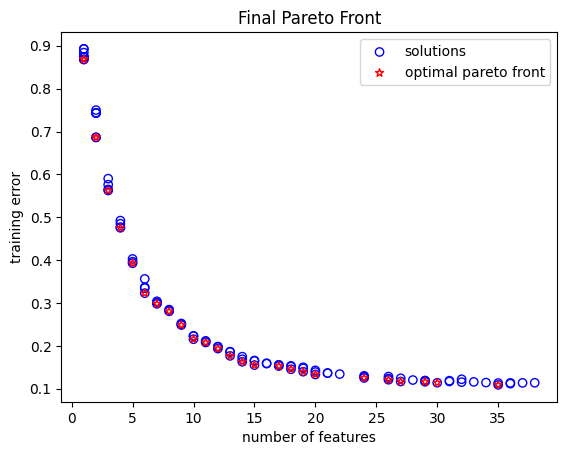

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 6.0
corresponding weights:  [0.         0.43325872 0.         0.         0.         0.
 0.         0.50169585 0.         0.        ] ...
corresponding normalized weights:  [0.         0.12480343 0.         0.         0.         0.
 0.         0.14451726 0.         0.        ] ...
classification error on train sets: 0.323045414671138
classification error on test sets: 0.39023861907225543
solution 1:
number of selected features is: 19.0
corresponding weights:  [0.         0.         0.32474491 0.         0.         0.3689466
 0.         0.59749283 0.68621541 0.69732271] ...
corresponding normalized weights:  [0.         0.         0.02891736 0.         0.         0.03285336
 0.         0.05320458 0.06110501 0.06209407] ...
classification error on train sets: 0.13975841945530942
classification error on test sets: 0.22634856413688642
solution 2:
number of selected fe

Final PF Results:  {0: {'num_selected_features': 6.0, 'feature_weights': [0.0, 0.43325871554818696, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5016958453961813, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6413820781512669, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6595216862025228, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6077947671935686, 0.0, 0.0, 0.0, 0.6278758721118957, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.323045414671138, 'test_error': 0.39023861907225543}, 1: {'num_selected_features': 19.0, 'feature_weights': [0.0, 0.0, 0.3247449120081172, 0.0, 0.0, 0.36894659671229235, 0.0, 0.597492829688372, 0.6862154094743093, 0.6973227084442285, 0.0, 0.0, 0.9969816262588006, 0.0, 0.9661726270029417, 0.0, 0.0, 0.0, 0.0, 0.5244838616017877, 0.0, 0.0, 0.6290891878792167, 0.0, 0.6437286116004103, 0.0, 0.0, 0.7879738803170704, 0.6345017280558982, 0.7148566191951053, 0.3440018646195461, 0.4228122980992004, 0.7032822859090779, 0.35510046038208826, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

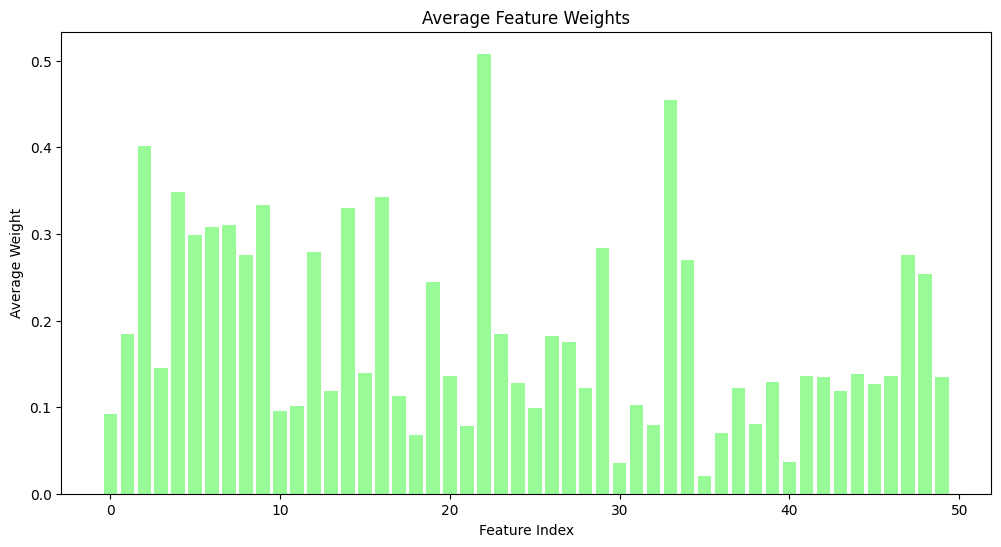

Total population members: 100
Pareto front members: 26


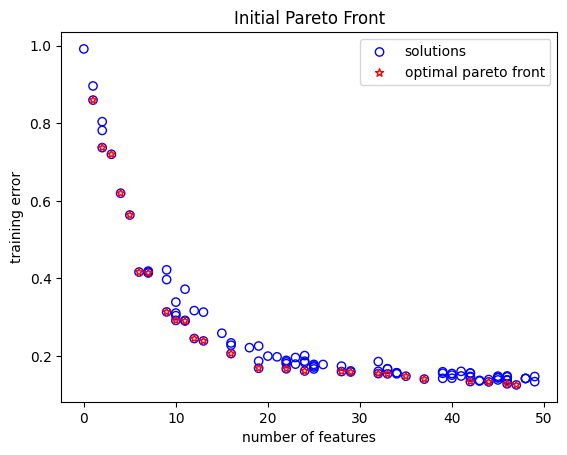

Total population members: 100
Pareto front members: 26


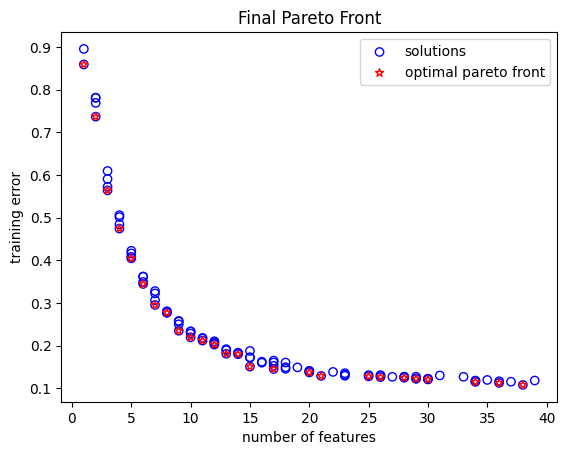

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 2.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.7369376521794782
classification error on test sets: 0.6948891871132526
solution 1:
number of selected features is: 1.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.8594761613627901
classification error on test sets: 0.9127240052683039
solution 2:
number of selected features is: 4.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.47440335629450703
classification error on test sets: 0.46516225993445637
solution 3:
number of selected features is: 3.0
corre

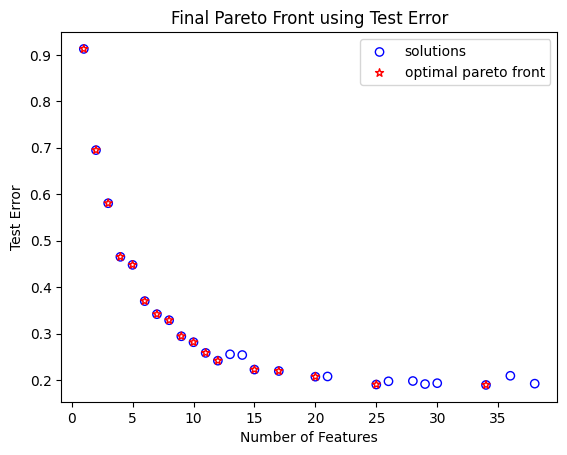

Final PF Results:  {0: {'num_selected_features': 2.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9672916406067864, 0.8372515984491896, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.7369376521794782, 'test_error': 0.6948891871132526}, 1: {'num_selected_features': 1.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.27028730685456837, 0.0, 0.0, 0.0], 'train_error': 0.8594761613627901, 'test_error': 0.9127240052683039}, 2: {'num_selected_features': 4.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7499087976037465, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

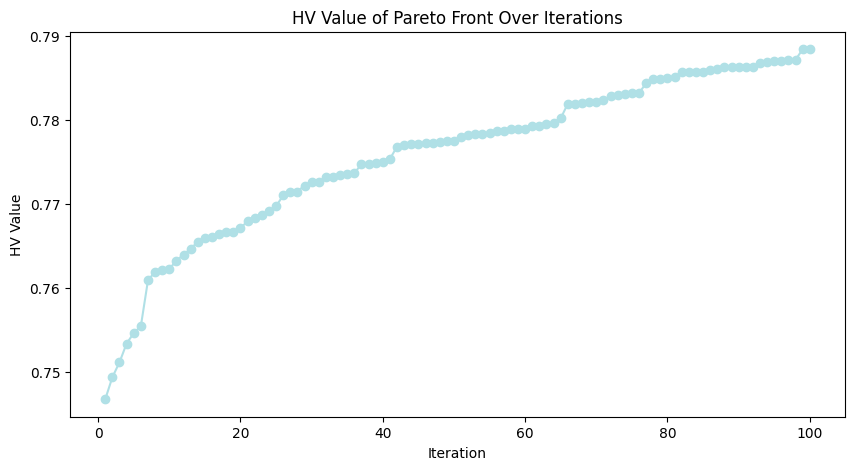

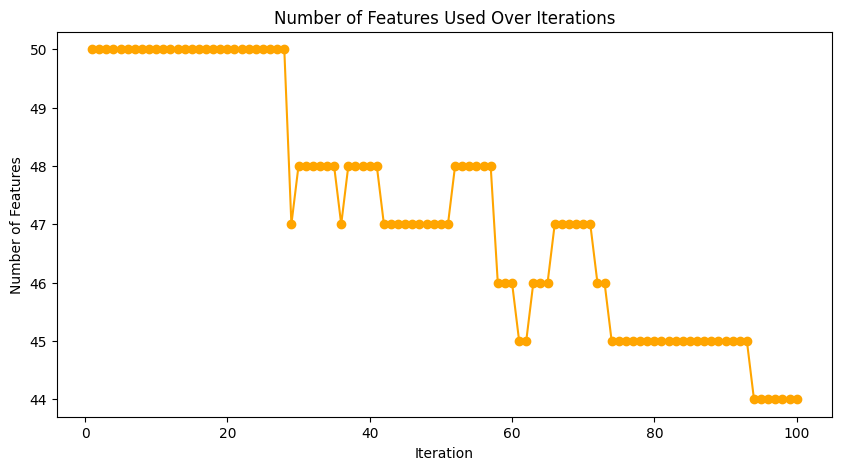

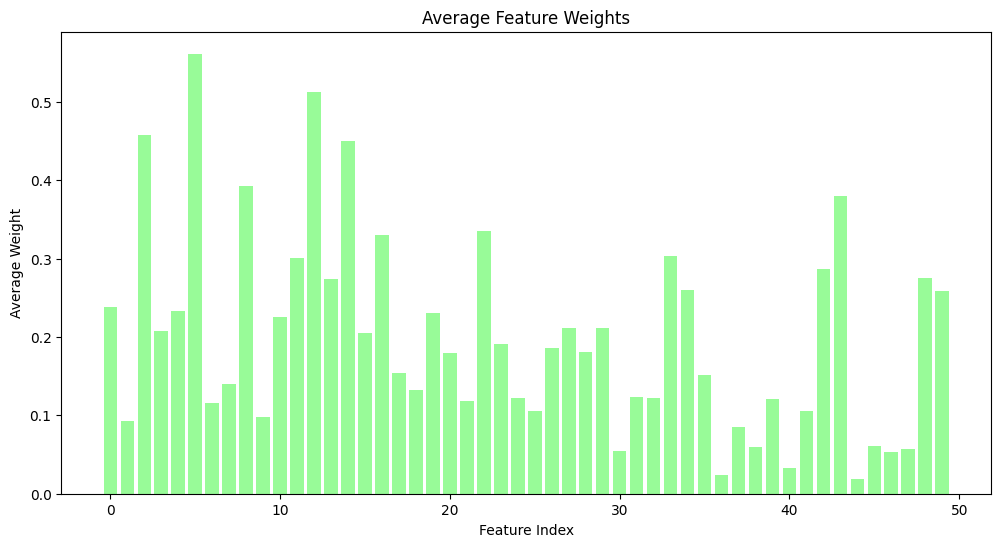

Total population members: 100
Pareto front members: 18


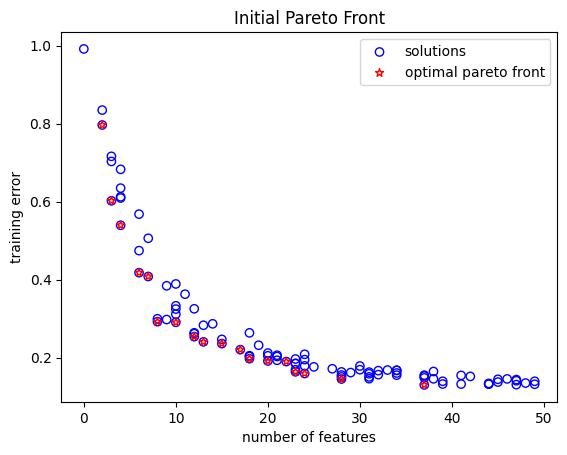

Total population members: 100
Pareto front members: 24


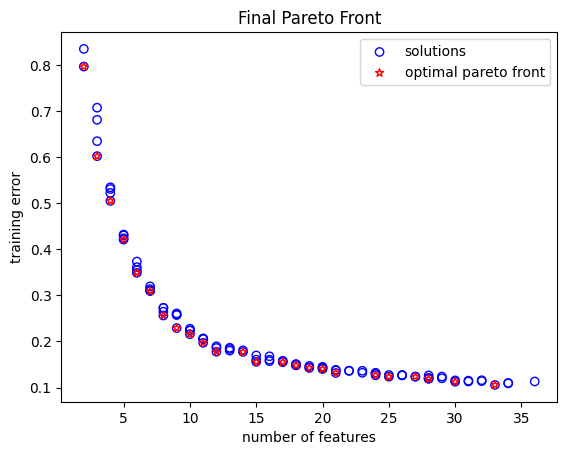

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 2.0
corresponding weights:  [0.         0.         0.02767838 0.         0.         0.
 0.         0.         0.         0.        ] ...
corresponding normalized weights:  [0.         0.         0.15153762 0.         0.         0.
 0.         0.         0.         0.        ] ...
classification error on train sets: 0.7962868713936159
classification error on test sets: 0.7468082666925169
solution 1:
number of selected features is: 3.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.6019942371799444
classification error on test sets: 0.6228229833247731
solution 2:
number of selected features is: 7.0
corresponding weights:  [0.         0.         0.52707469 0.         0.         0.67198251
 0.         0.         0.         0.        ] ...
correspo

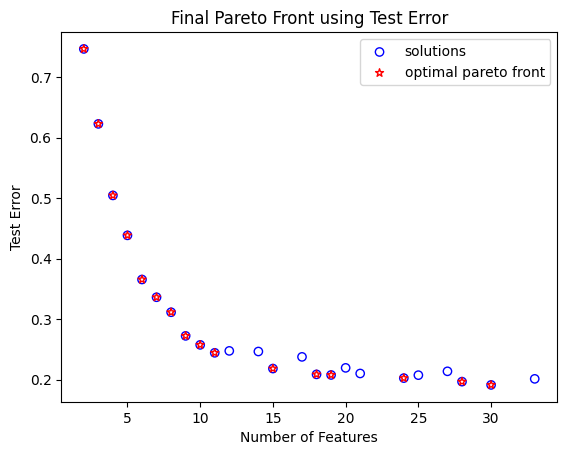

Final PF Results:  {0: {'num_selected_features': 2.0, 'feature_weights': [0.0, 0.0, 0.02767838117428608, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15497184463713062, 0.0, 0.0], 'train_error': 0.7962868713936159, 'test_error': 0.7468082666925169}, 1: {'num_selected_features': 3.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8366885873364364, 0.8594191222218887, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6203198515959292, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.6019942371799444, 'test_error': 0.6228229833247731}, 2: {'num_selected_features': 7.0, 'feature_weights': [0.0, 0.0, 0.5270746861071618, 0.0, 0.0, 0.6719825070783016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8454405

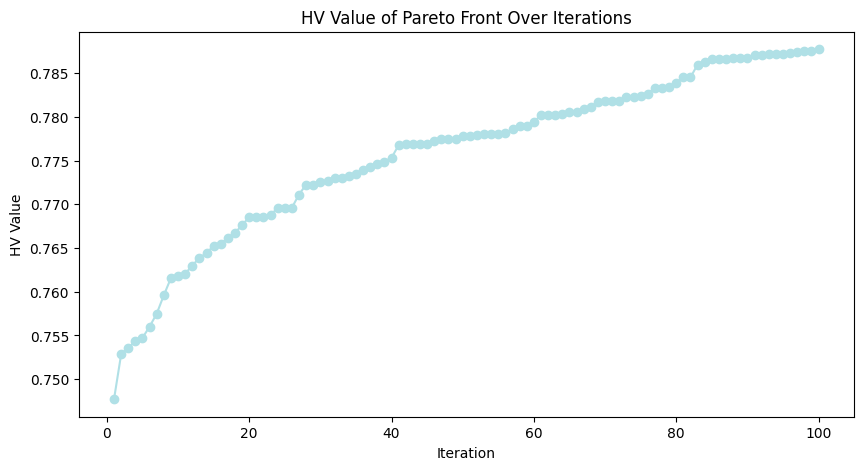

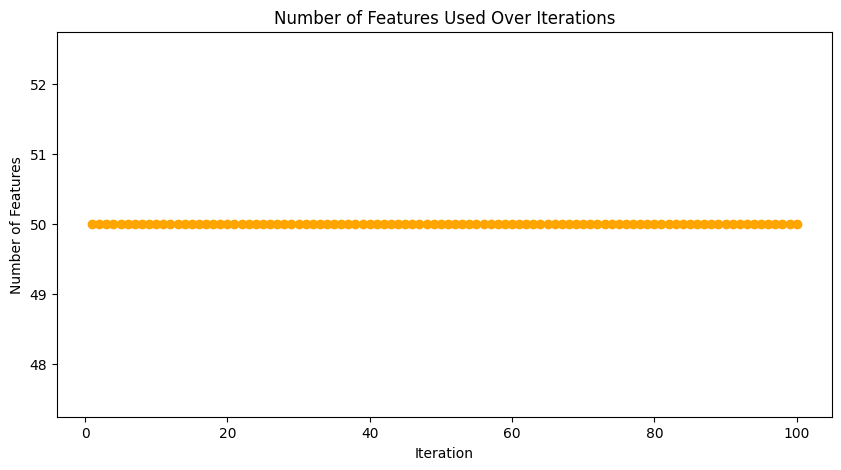

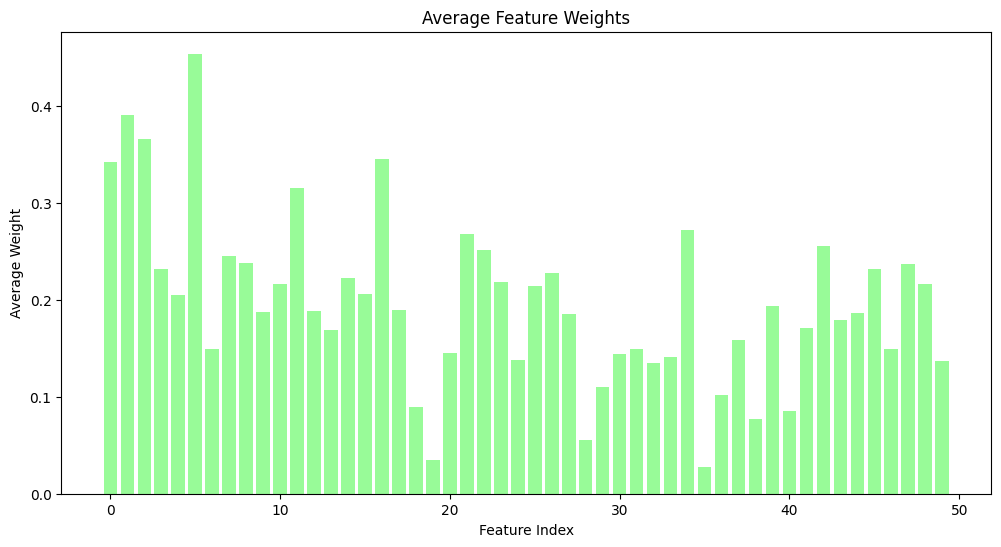

Total population members: 100
Pareto front members: 22


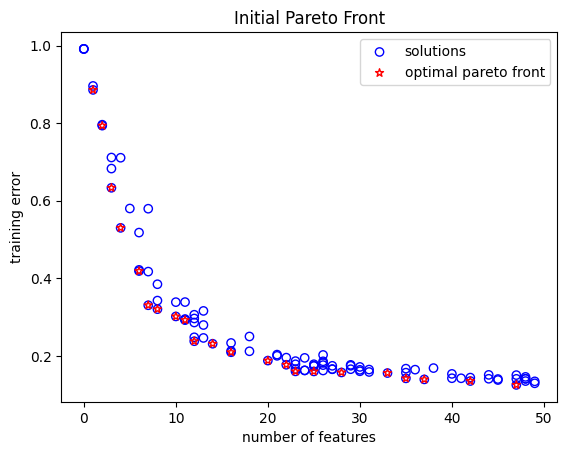

Total population members: 100
Pareto front members: 30


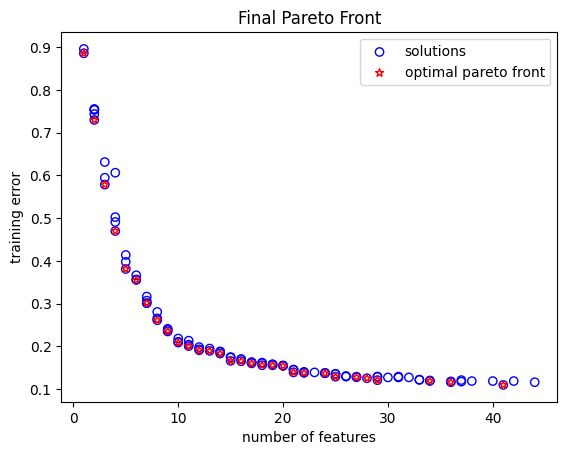

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.885657916705953
classification error on test sets: 0.8845769119976389
solution 1:
number of selected features is: 13.0
corresponding weights:  [0.91766707 0.79877999 0.         0.74781588 0.92377571 0.77417553
 0.         0.93357653 0.         0.        ] ...
corresponding normalized weights:  [0.10182644 0.08863445 0.         0.08297936 0.10250426 0.08590429
 0.         0.10359179 0.         0.        ] ...
classification error on train sets: 0.1896164431336671
classification error on test sets: 0.22487246535517003
solution 2:
number of selected features is: 6.0
corresponding weights:  [0.         0.         0.38808318 0.         0.29022246 0.
 0.         0.         0.         0.22619176] ...

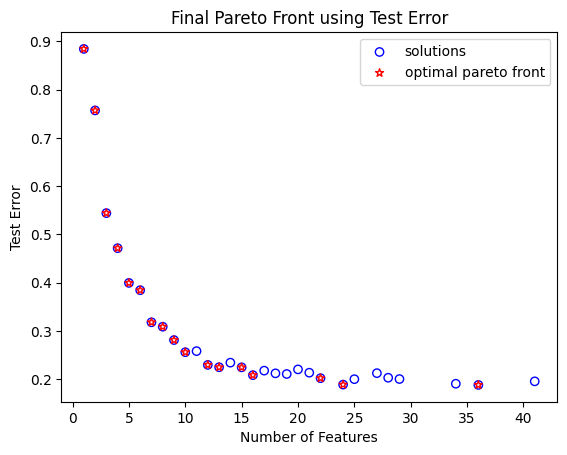

Final PF Results:  {0: {'num_selected_features': 1.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012310489302657057, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.885657916705953, 'test_error': 0.8845769119976389}, 1: {'num_selected_features': 13.0, 'feature_weights': [0.9176670723197752, 0.7987799878701909, 0.0, 0.7478158751088166, 0.9237757130704819, 0.7741755323919498, 0.0, 0.9335765348892737, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7595203119609049, 0.5333250907939322, 0.0, 0.0, 0.48272499787516804, 0.8009331383628958, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010491888334888256, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6555121013250094, 0.0, 0.6737727655037951, 0.0, 0.0], 'train_error': 0.1896164431336671, 'test_error': 0.22487246535517003}, 2: {'num_selec

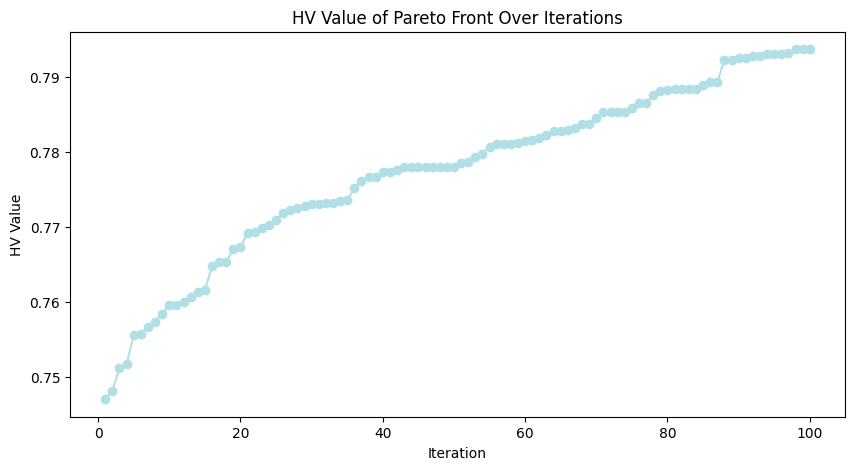

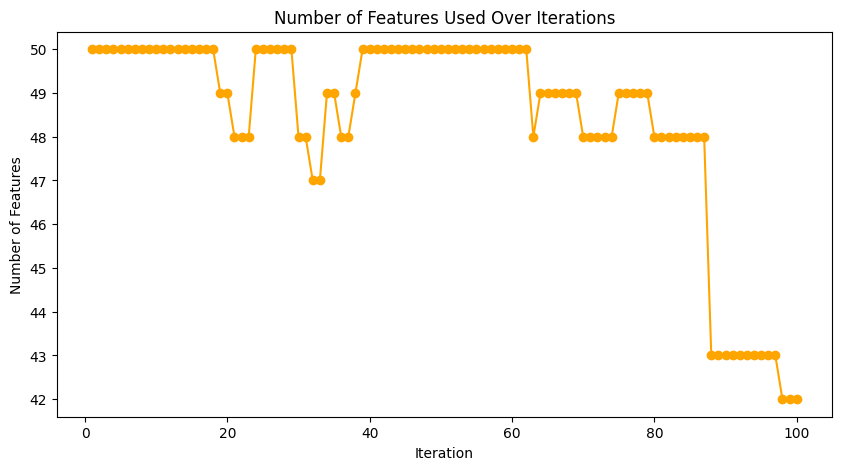

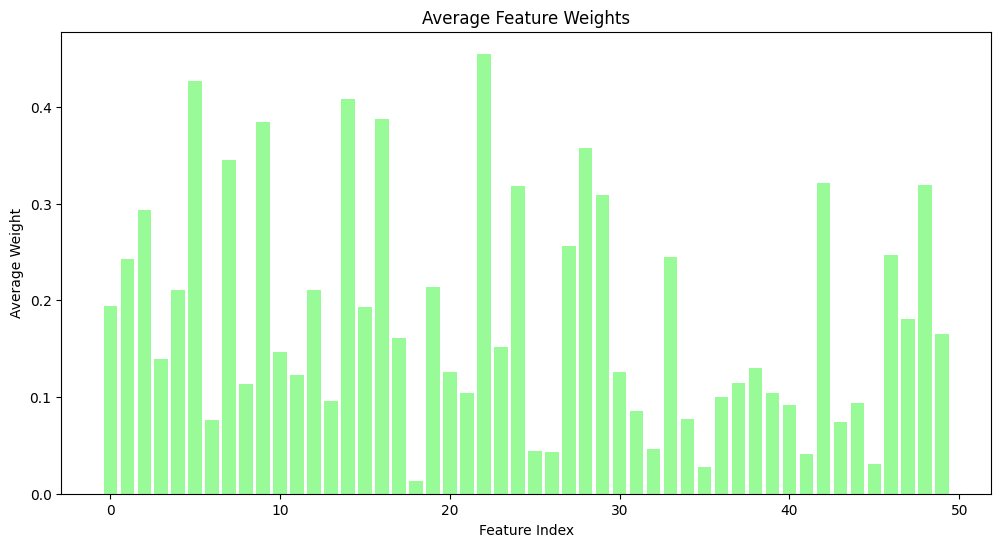

Total population members: 100
Pareto front members: 23


Total population members: 100
Pareto front members: 24


##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.8812030334161925
classification error on test sets: 0.9061070769328197
solution 1:
number of selected features is: 16.0
corresponding weights:  [0.37809747 0.53736384 0.73259466 0.         0.64201833 0.64519111
 0.         0.54802505 0.         0.54391687] ...
corresponding normalized weights:  [0.04180882 0.05941999 0.081008   0.         0.07099236 0.07134319
 0.         0.06059888 0.         0.06014461] ...
classification error on train sets: 0.15699299591158167
classification error on test sets: 0.2291103000092407
solution 2:
number of selected features is: 18.0
corresponding weights:  [0.68430953 0.         0.         0.         0.44404457 0.84467226
 0.         0.         0.         0.471

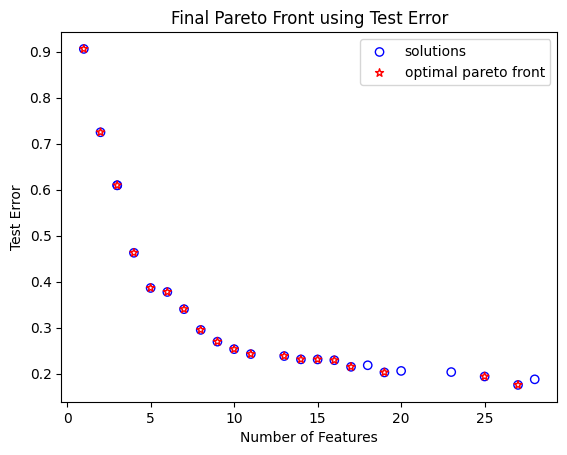

Final PF Results:  {0: {'num_selected_features': 1.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15179165222119656, 0.0, 0.0], 'train_error': 0.8812030334161925, 'test_error': 0.9061070769328197}, 1: {'num_selected_features': 16.0, 'feature_weights': [0.3780974740218325, 0.5373638378084992, 0.7325946600834853, 0.0, 0.642018328530027, 0.6451911071973601, 0.0, 0.5480250530081326, 0.0, 0.5439168699650683, 0.0, 0.0, 0.5222758609501336, 0.0, 0.6560550768708263, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8502505922673894, 0.0, 0.0, 0.0, 0.0, 0.0, 0.882018467523609, 0.0, 0.0, 0.0, 0.0, 0.6299479293843901, 0.0, 0.0, 0.0, 0.05197803327322832, 0.2953492618936896, 0.0, 0.0, 0.0, 0.49443410196474236, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6339684728181095, 0.0], 'train_error': 0.15699299591158167, 'test_e

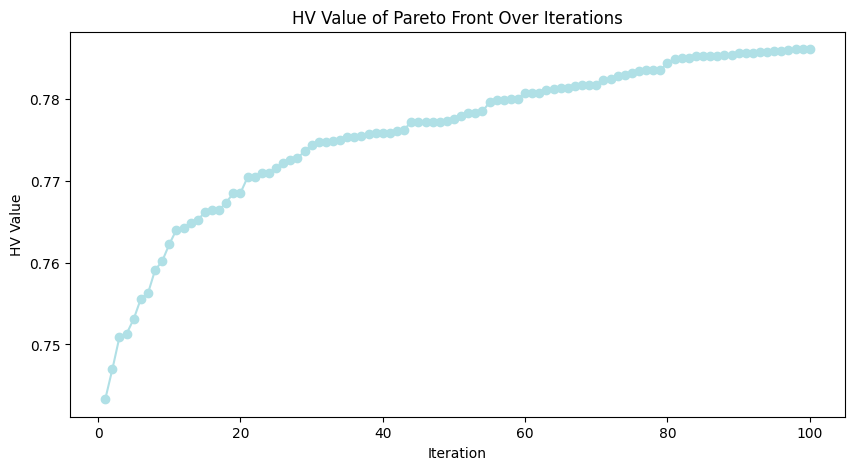

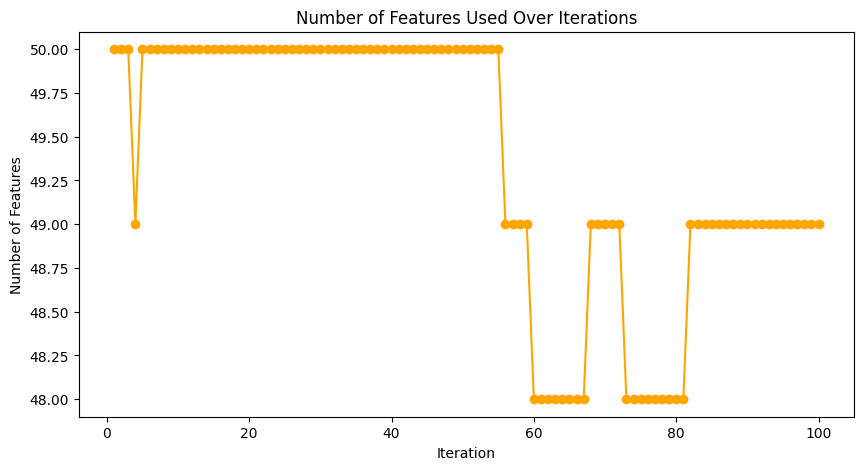

Total population members: 100
Pareto front members: 18


Total population members: 100
Pareto front members: 28


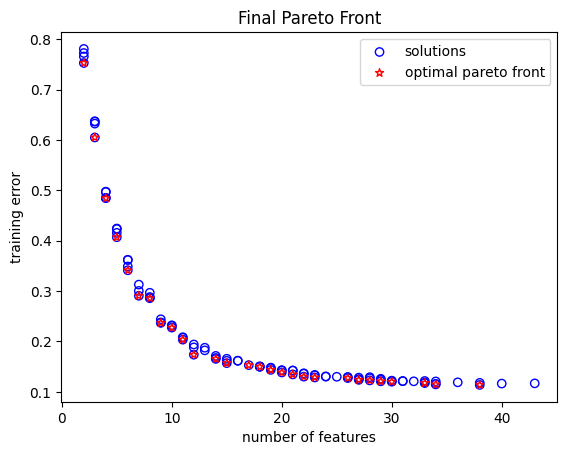

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 38.0
corresponding weights:  [0.4329044  0.28045765 0.90690423 0.         0.98982508 0.76897667
 0.         0.25659006 0.99146664 0.75349648] ...
corresponding normalized weights:  [0.01939729 0.01256656 0.04063596 0.         0.04435143 0.0344558
 0.         0.01149712 0.04442498 0.03376217] ...
classification error on train sets: 0.11367158905096153
classification error on test sets: 0.19648023695900962
solution 1:
number of selected features is: 7.0
corresponding weights:  [0.         0.39354529 0.3545984  0.         0.         0.
 0.         0.         0.         0.        ] ...
corresponding normalized weights:  [0.         0.11590045 0.10443046 0.         0.         0.
 0.         0.         0.         0.        ] ...
classification error on train sets: 0.2907596101413884
classification error on test sets: 0.36558504367461153
solution 2:
number of selected f

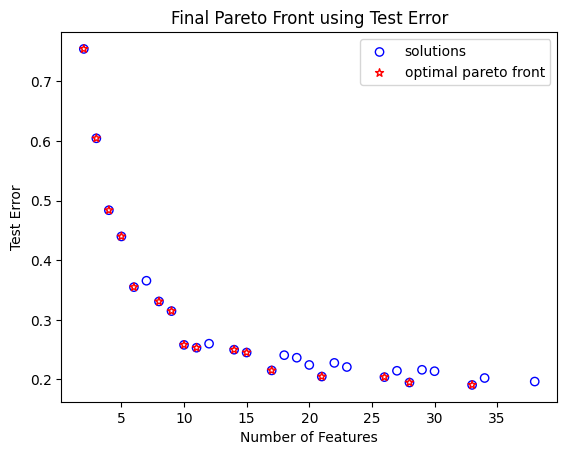

Final PF Results:  {0: {'num_selected_features': 38.0, 'feature_weights': [0.43290439609614806, 0.2804576467528408, 0.9069042283504299, 0.0, 0.9898250785078281, 0.7689766731226724, 0.0, 0.25659006146000074, 0.9914666394023488, 0.7534964822165704, 0.0, 0.296092935431957, 0.790116072948771, 0.5935919973899774, 0.9975229957675236, 0.9943488218863407, 0.9765011587841315, 0.5236100983332849, 0.24539153877025702, 0.4015012220663458, 0.01892437341552127, 0.0, 0.7834448276669673, 0.012855490193177416, 0.0, 0.5943035040311568, 0.7128554646437446, 0.0, 0.0, 0.9114810622117371, 0.3112579613141682, 0.0, 0.0, 0.7176276571104415, 0.7367786292106344, 0.015124651342644685, 0.0, 0.24011966438113008, 0.6754583103477119, 0.6320726720299933, 0.0, 0.7901531229660687, 0.4018645001207549, 0.2435439629904046, 0.7624280405802922, 0.0, 0.49112293664252554, 0.5616242075241371, 0.7012738645034627, 0.8041601279186092], 'train_error': 0.11367158905096153, 'test_error': 0.19648023695900962}, 1: {'num_selected_featur

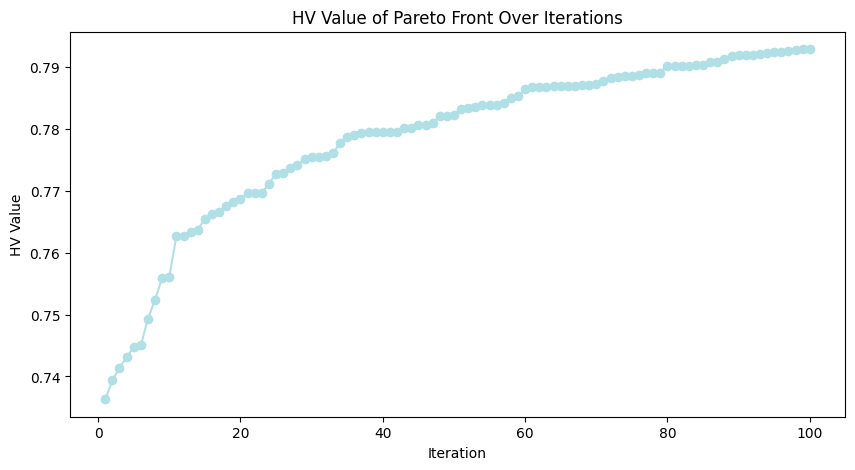

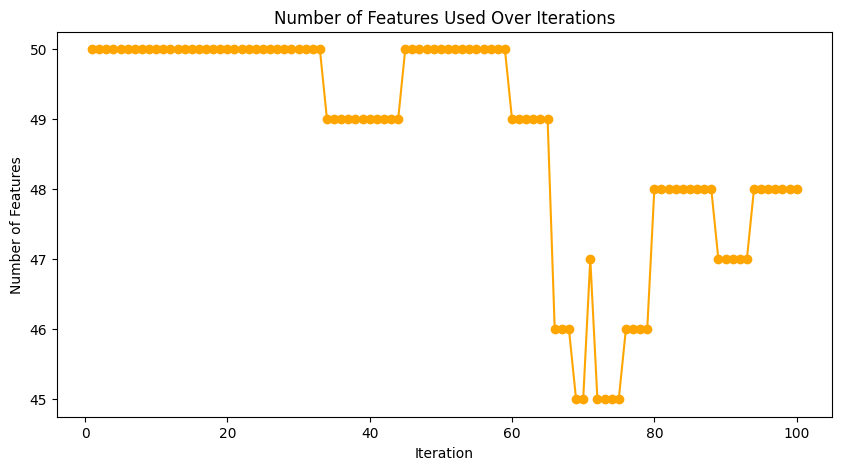

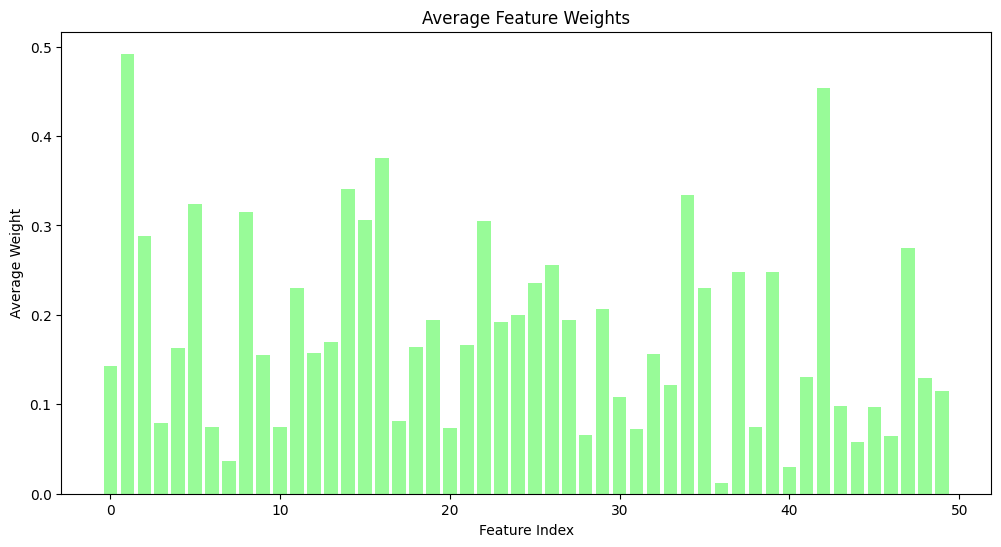

Total population members: 100
Pareto front members: 21


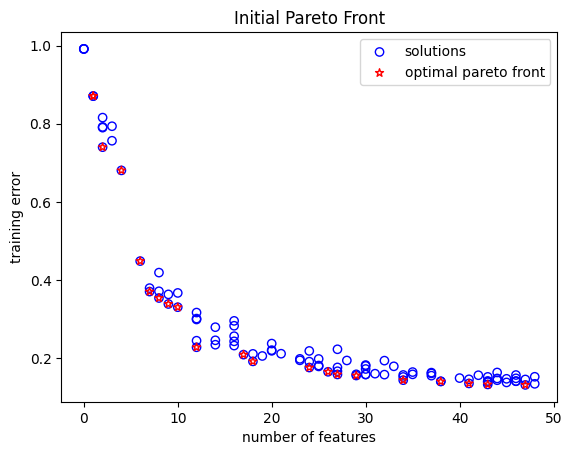

Total population members: 100
Pareto front members: 26


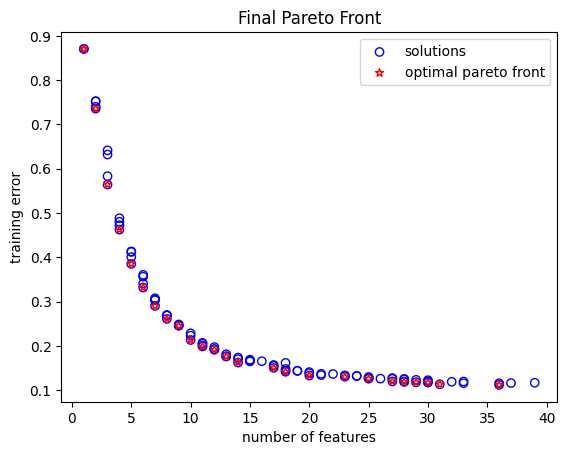

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.870651051601633
classification error on test sets: 0.8995574051213836
solution 1:
number of selected features is: 1.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.870651051601633
classification error on test sets: 0.8995574051213836
solution 2:
number of selected features is: 23.0
corresponding weights:  [0.77935185 0.9141189  0.38083634 0.         0.74734389 0.66824843
 0.         0.         0.54114831 0.        ] ...
corresponding normalized weights:  [0.06244646 0.07324482 0.03051495 0.         0.05988178 0.05354417
 0.         0.         0.04336013 0.        ] ...
cla

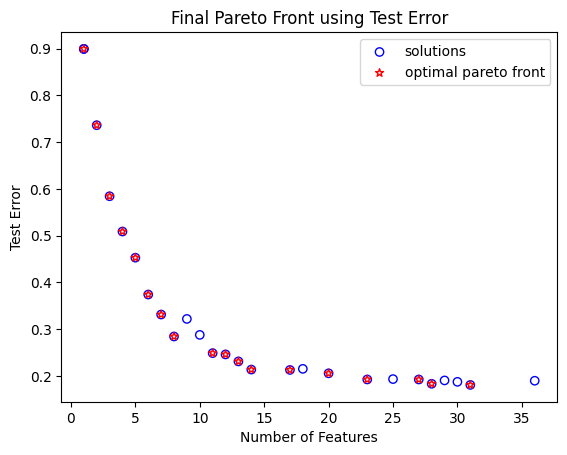

Final PF Results:  {0: {'num_selected_features': 1.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26309212176194446, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.870651051601633, 'test_error': 0.8995574051213836}, 1: {'num_selected_features': 1.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.40117050503814905, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.870651051601633, 'test_error': 0.8995574051213836}, 2: {'num_selected_features': 23.0, 'feature_weights': [0.7793518485480433, 0.9141189026772859, 0.3808363391030953, 0.0, 0.7473438861139787, 0.6682484255283884, 0.0, 0.0, 0.5411483116693716, 0.0, 0.0, 

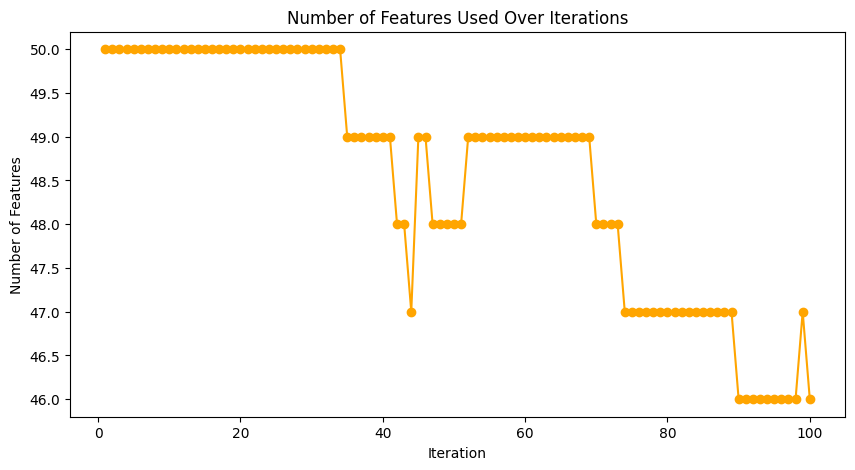

Total population members: 100
Pareto front members: 19


Total population members: 100
Pareto front members: 27


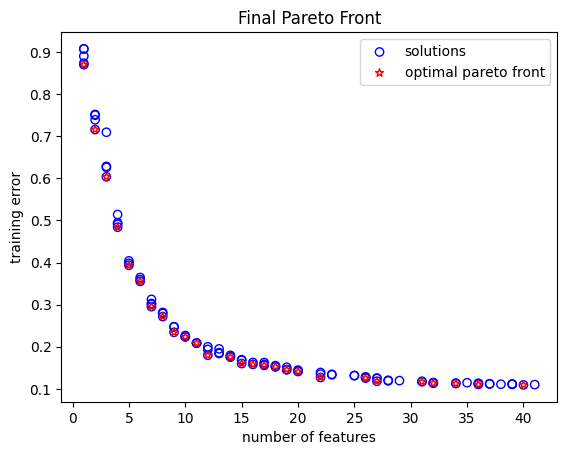

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding weights:  [0.         0.         0.24634843 0.         0.         0.
 0.         0.         0.         0.        ] ...
corresponding normalized weights:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.8701658728253405
classification error on test sets: 0.8763028041286546
solution 1:
number of selected features is: 6.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.35534589972730724
classification error on test sets: 0.3927749296079114
solution 2:
number of selected features is: 3.0
corresponding weights:  [0.         0.         0.18873357 0.         0.         0.
 0.39054818 0.         0.         0.        ] ...
corresponding normalized weights:  [0.         0.         0.2844527  0.         0.      

Final PF Results:  {0: {'num_selected_features': 1.0, 'feature_weights': [0.0, 0.0, 0.24634842570398277, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.8701658728253405, 'test_error': 0.8763028041286546}, 1: {'num_selected_features': 6.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6173258440904626, 0.0, 0.0, 0.0, 0.0, 0.6585198309221885, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5105559307098225, 0.0, 0.0, 0.0, 0.7325987419263308, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5469063231140849, 0.0, 0.0, 0.0, 0.0, 0.734292357144704, 0.0], 'train_error': 0.35534589972730724, 'test_error': 0.3927749296079114}, 2: {'num_selected_features': 3.0, 'feature_weights': [0.0, 0.0, 0.1887335692345982, 0.0, 0.0, 0.0, 0.39054818459464946, 0.0,

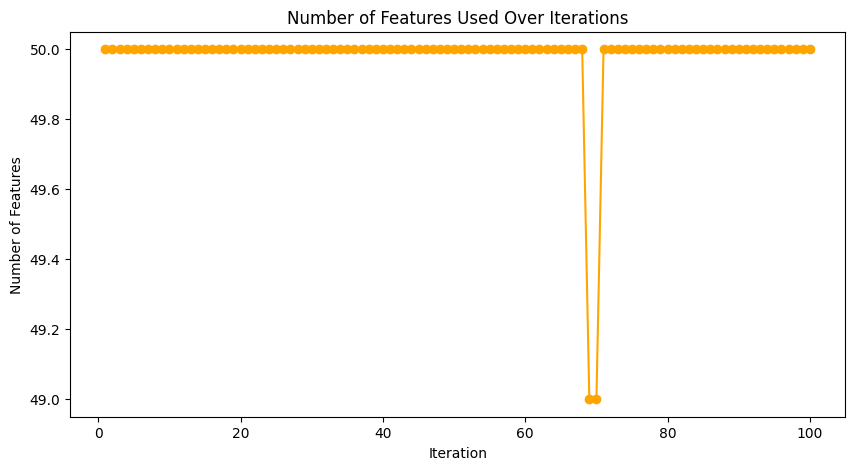

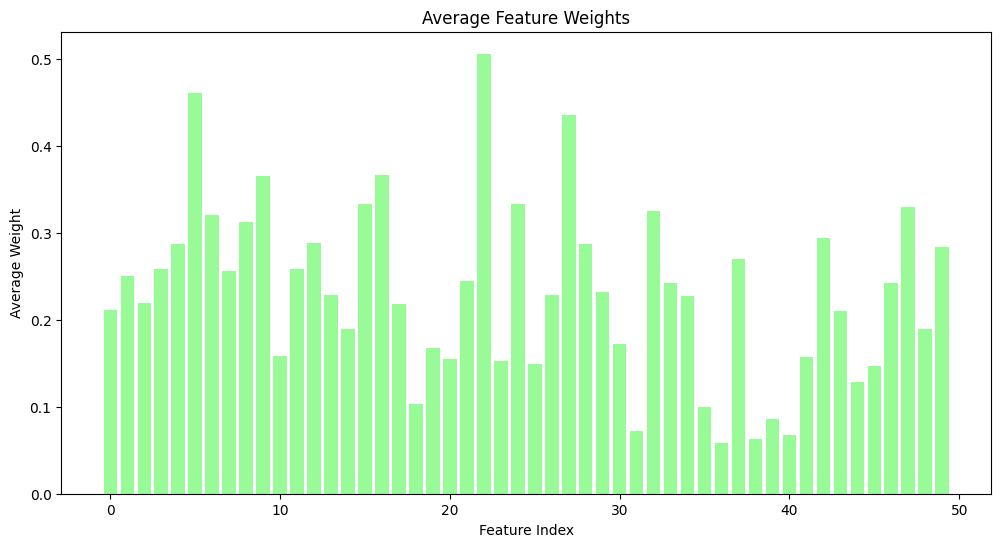

Total population members: 100
Pareto front members: 24


Total population members: 100
Pareto front members: 32


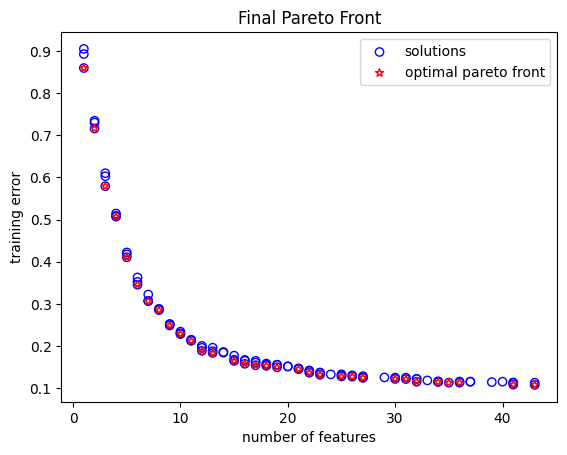

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
corresponding normalized weights:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...
classification error on train sets: 0.8594761613627901
classification error on test sets: 0.9127240052683039
solution 1:
number of selected features is: 5.0
corresponding weights:  [0.         0.34699882 0.         0.         0.         0.22579627
 0.         0.         0.         0.        ] ...
corresponding normalized weights:  [0.         0.19127933 0.         0.         0.         0.12446774
 0.         0.         0.         0.        ] ...
classification error on train sets: 0.4104474713681404
classification error on test sets: 0.42831588980756974
solution 2:
number of selected features is: 22.0
corresponding weights:  [0.         0.         0.         0.77655868 0.37537965 0.09739006
 0.         0.7797968  0.55491659 0.9415

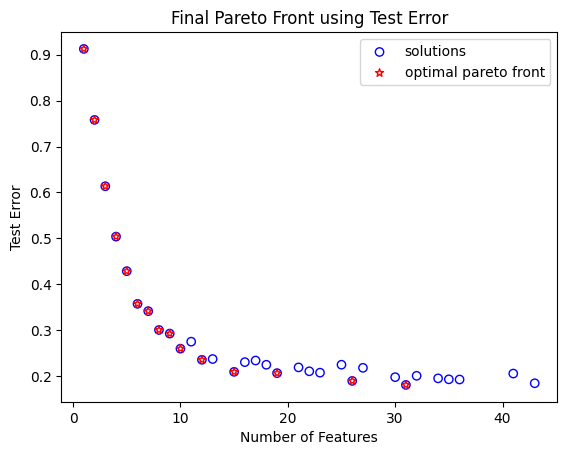

Final PF Results:  {0: {'num_selected_features': 1.0, 'feature_weights': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7655338616671794, 0.0, 0.0, 0.0], 'train_error': 0.8594761613627901, 'test_error': 0.9127240052683039}, 1: {'num_selected_features': 5.0, 'feature_weights': [0.0, 0.34699881638115376, 0.0, 0.0, 0.0, 0.22579626591441848, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7074788701302474, 0.2719594315660504, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2618612782785873, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'train_error': 0.4104474713681404, 'test_error': 0.42831588980756974}, 2: {'num_selected_features': 22.0, 'feature_weights': [0.0, 0.0, 0.0, 0.7765586839862753, 0.37537965360827813, 0.09739005675423447, 0.0, 

In [64]:
# Run algorithm again, but this time with top 50 features
# Read top 50 features
top_50 = pd.read_csv("Top_NSGA2_Features.csv").head(50)
print(top_50)
# Read validation data
validation_path = "KimiaNet_Data/kimianet_validation_data_averaged_feature_vectors.csv"
validation = pd.read_csv(validation_path)
dclass = validation.columns[0]
x = validation.drop(columns=[dclass])
y = validation[dclass]
featureNames = []
for i in top_50['Feature'].tolist():
    featureNames.append(x.columns[i-1]) #featureNames has feature names from 1-1024, not indices; so, to access feature x, we need to go to index i-1
print(featureNames)
x = x[featureNames]
# Read test data
test_path = "KimiaNet_Data/kimianet_test_data_averaged_feature_vectors.csv"
test = pd.read_csv(test_path)
dclass = test.columns[0]
xtest = test.drop(columns=[dclass])
ytest = test[dclass]
featureNames = []
for i in top_50['Feature'].tolist():
    featureNames.append(xtest.columns[i-1]) 
xtest = xtest[featureNames]

# Run GDE3 algorithm 10 times
epsilon = 0.01
total_features = x.shape[1] 
popsize=100
print("TOTAL NUMBER OF FEATURES: ", total_features)
for run in range(10):
    print("*"*50, f"RUN {run+1}", "*"*50)
    dataset_name = f"RUN {run+1}: GDE3 Kimianet Feature Weighting"

    custom_population = generate_individuals(total_features, epsilon, popsize)
    pop = Population.new("X", custom_population)

    problem = MyProblem(x,y,epsilon)
    Evaluator().eval(problem, pop) # evaluate initial population
    algorithm = GDE3(pop_size=popsize,
                    variant="DE/rand/1/bin", # selection = random, crossover = binary
                    CR=0.5, # crossover parameter [0,1]
                    F=(0.0, 0.9), # scale factor or mutation parameter (0,2]
                    sampling = pop
                    )
    res = minimize(problem,
                    algorithm,
                    ("n_gen", 100),
                    verbose=True, # prints results if true
                    save_history=True
                    )
    '''
    ALGORITHM DESCRIPTION
    The algorithm generates new solutions for the next generation by iteratively selecting each solution in the current generation (called the target vector) and performing the following steps:
    1. Selecting two random solutions from the current generation to calculate a difference vector.
    2. Scaling the difference vector by a factor F.
    3. Adding the scaled difference vector to a third random solution (called the base vector) to form a mutant vector, which becomes a candidate solution.
    4. Performing crossover between the target vector (current solution) and the mutant vector to form a trial vector.
    5. Evaluating the trial vector to determine if it should replace the target vector in the next generation (based on its fitness/performance).
    This process is repeated for each solution in the current generation.
    PARAMS DESCRIPTION
    pop_size: number of individuals in each generation
    variant: format of DE strategy as "DE/selection/n/crossover", where
        1. selection = how the base vector is selected when forming the mutant vector 
            (e.g., rand = base vector is chose randomly, best = best performing solution in current generation is always chosen as the base vector)
        2. n = number of difference vectors used for mutation 
            (e.g., 1 = one difference vector is used)
        3. crossover = how crossover is performed between the target vector and mutant vector to form the trial vector
            (e.g., bin = each component (i.e., each feature weight) of the offspring is selected either from the mutant vector or from the current parent vector based on probability CR)
    CR: crossover probability of the trial vector inheriting a component from the mutant vector (higher CR = more likely to inherit mutant component)
    F: scaling factor of difference vector; higher value leads to larger mutations and more exploration, lower value leads to smaller mutations and more exploitation (fine-tuning)
        (e.g., (0.0-0.9) means a random scaling factor will be chosen between 0 - 0.9 for each candidate solution in the next generation)
    sampling: used to manually input an initial generation
    '''

    final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training = visualize(res, x, y, xtest, ytest, epsilon)
    store_results(dataset_name, final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training, epsilon, featureNames)

In [87]:
# Analyze results of the runs

def analyze(startrow, endrow):
    # Fetch results of all runs
    csv_file_path = 'data.csv'  
    df = pd.read_csv(csv_file_path)
    filtered_df = df.iloc[startrow:endrow].reset_index() # rows with new kimianet NSGA runs
    print("*"*25, "Runs considered", "*"*25)
    print(filtered_df['Dataset'])

    # Get average error and number of features from the best solution in each run
    print("*"*25, f"Average Results Over {filtered_df.shape[0]} Runs", "*"*25)
    print(f"Final Training PF: average error & number of features for the best solution = {round(filtered_df['Minimum error on training PF'].mean(), 4)}, {int(filtered_df['Number of features for minimum error on training PF'].mean())}")
    print(f"Final Test PF: average error & number of features for the best solution = {round(filtered_df['Minimum error on testing PF'].mean(), 4)}, {int(filtered_df['Number of features for minimum error on testing PF'].mean())}")

    # Get the two solutions with the lowest training/testing error and the corresponding number of features for both
    min_training_error_row = filtered_df.loc[filtered_df['Minimum error on training PF'].idxmin()]
    min_test_error_row = filtered_df.loc[filtered_df['Minimum error on testing PF'].idxmin()]
    print("*"*25, "Lowest Error Results", "*"*25)
    print(f"Lowest training error: {round(min_training_error_row['Minimum error on training PF'], 4)}, Number of features: {int(min_training_error_row['Number of features for minimum error on training PF'])}")
    print(f"Lowest test error: {round(min_test_error_row['Minimum error on testing PF'],4)}, Number of features: {int(min_test_error_row['Number of features for minimum error on testing PF'])}")

    # Get total number of solutions across the final training pareto front of all runs
    print("*"*25, "Total Number of Solutions in the Final Pareto Front", "*"*25)
    total_solutions = 0
    for i, pf_dict_str in filtered_df['Training PF'].items():
        pf_dict = eval(pf_dict_str)
        num_solutions = len(pf_dict)
        print(f"Run {i+1}: {num_solutions} solution(s)")
        total_solutions += num_solutions
    print(f"Total number of solutions across all runs: {total_solutions}")

    # Sort features based on how many solutions they appeared in across the final training pareto front of all runs
    total_feature_freq = Counter()
    feature_run_freq = Counter()
    for feature_freq_str in filtered_df['Feature Frequency']:
        feature_freq_pairs = feature_freq_str.split(', ')
        for pair in feature_freq_pairs:
            feature, freq = pair.split(': ')
            total_feature_freq[feature] += int(freq)
            feature_run_freq[feature] += 1
    sorted_feature_freq = sorted(total_feature_freq.items(), key=lambda x: x[1], reverse=True)
    rank=1
    print("*"*25, "Feature Occurrence Ranking", "*"*25)
    for feature, freq in sorted_feature_freq:
        run_count = feature_run_freq[feature]
        print(f"Rank {rank} - Feature {feature}: {freq} occurrence(s) in {run_count}/{filtered_df.shape[0]} runs ({round((freq/total_solutions) * 100, 4)}% of total solutions)")
        rank+=1
    return

analyze(54, 64) # runs using top 100 features
analyze(64, 74) # runs using top 50 features




************************* Runs considered *************************
0     RUN 1: GDE3 Kimianet Feature Weighting
1     RUN 2: GDE3 Kimianet Feature Weighting
2     RUN 3: GDE3 Kimianet Feature Weighting
3     RUN 4: GDE3 Kimianet Feature Weighting
4     RUN 5: GDE3 Kimianet Feature Weighting
5     RUN 6: GDE3 Kimianet Feature Weighting
6     RUN 7: GDE3 Kimianet Feature Weighting
7     RUN 8: GDE3 Kimianet Feature Weighting
8     RUN 9: GDE3 Kimianet Feature Weighting
9    RUN 10: GDE3 Kimianet Feature Weighting
Name: Dataset, dtype: object
************************* Average Results Over 10 Runs *************************
Final Training PF: average error & number of features for the best solution = 0.1073, 61
Final Test PF: average error & number of features for the best solution = 0.1788, 50
************************* Lowest Error Results *************************
Lowest training error: 0.1037, Number of features: 79
Lowest test error: 0.1737, Number of features: 39
*********************